# Analysis of the libraries

Here we plot the major base frequency for different time points.
We also detect positions that consistently rise in frequency through time, i.e. positions that rise monotonously in frequency with time. Positions that only rise in frequency between the first and the last time points have not been investigated.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
from array import array
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
%matplotlib inline

# Obtaining the sequence annotation

In [4]:
begins=[]
ends=[]
names =[]
with open ("sequence.gb") as f:
    in_pep = False
    for l in f:
        if "mat_peptide" in l:
            begins.append(int(l.split()[1].split("..")[0]))
            ends.append(int(l.split()[1].split("..")[1]))
            in_pep = True
        elif in_pep :
            names.append(l.split("=")[1])
            in_pep = False
            
print(begins)
print(ends)
print(names)

[108, 474, 753, 978, 2490, 3546, 4224, 4614, 6465, 6846, 6915, 7668]
[473, 752, 977, 2489, 3545, 4223, 4613, 6464, 6845, 6914, 7667, 10376]
['"capsid"\n', '"propeptide"\n', '"membrane"\n', '"envelope"\n', '"NS1"\n', '"NS2A"\n', '"NS2B"\n', '"NS3"\n', '"NS4A"\n', '"2K"\n', '"NS4B"\n', '"NS5"\n']


# Functions to plot interesting positions and gene boundaries

In [5]:
# Interesting positions
positions=[316,1670,1785,2340,5935,7172,8449,9165]
def plot_positions():
    for x in positions:
        plt.axvline(x=x, linewidth=1, linestyle=':')
        
def plot_genes():
    for i in range(len(begins)):
        plt.plot([begins[i], begins[i]], [0.99,1.0], linewidth=2, linestyle='-', color="black")
        if i%2==0:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.005, (names[i].replace('"', ''))[0:3], size='xx-small')
        else:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.015, (names[i].replace('"', ''))[0:3], size='xx-small')
    plt.plot([ends[-1], ends[-1]], [0.99,1.0], linewidth=2, linestyle='-', color="black")

# Function to add useful columns to the tables 

In [6]:
def synonymous (row):
    if row['null'] or (row['consensus_aa']==row['secondbase_aa'] ):
        return "synonymous" 
    else:
        return "non-synonymous"

def add_columns(table):
    table['null'] = (table['secondbase_aa']).isnull()
    table['is_synonymous'] = table.apply (lambda row: synonymous (row),axis=1)
    table['1_major_variant_frequency'] = 1.0 - table['Major_variant_frequency_quality_corrected']


# Functions to detect variants increasing in frequency

In [7]:

def is_increasing(minor_frequencies):
    #print(minor_frequencies)
    previous = minor_frequencies[0]
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m]:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True

def get_variant_frequency(variant, table, i):
    sum_of_bases = table['As_quality_corrected'][i]+table['Cs_quality_corrected'][i]+table['Gs_quality_corrected'][i]+table['Ts_quality_corrected'][i]+table['Ns_quality_corrected'][i]
    if variant == "A":
        return table["As_quality_corrected"][i] / sum_of_bases
    elif variant == "C":
        return table["Cs_quality_corrected"][i] / sum_of_bases
    elif variant == "G":
        return table["Gs_quality_corrected"][i] / sum_of_bases
    elif variant == "T":
        return table["Ts_quality_corrected"][i] / sum_of_bases
    else:
        return np.nan
        

def get_increasing_variants(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    increasingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        if major == last["Major_variant"][i]:
            minor = last["Second_variant"][i]
        else:
            minor = last["Major_variant"][i]
        minor_frequencies[0] = get_variant_frequency(minor, first, i)
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
            minor_frequencies[table_id] = get_variant_frequency(minor, tables[table_id], i)
        if is_increasing(minor_frequencies):
            increasingVariants[i] = [major_frequencies.tolist(), minor_frequencies.tolist()]
    return increasingVariants

# Reading all data

In [8]:
# CirSeq initial sample
cirseq = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1CirseqD3_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(cirseq)

In [9]:
# Control runs, replicate A
DD3_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD3_A)
DD6_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD6_A)
DD9_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD9_A)
DD12_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD12_A)
DD24_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD24_A)
DD51_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A)
DD51_A_no_reamp = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51Anoreamplification_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A_no_reamp)

In [10]:
# Control runs, replicate D
DD3_D = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD3_D)
DD6_D = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD6_D)
DD9_D = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD9_D)
DD12_D = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD12_D)
DD24_D = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD24_D)

In [11]:
# Control runs, replicate E
DD6_E = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD6_E)
DD9_E = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD9_E)

In [12]:
# TLR3 activation runs, replicate A
TD9_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_A)
TD12_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD12_A)
TD24_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD24_A)
TD51_A = pd.read_csv ("HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD51_A)


In [13]:
#DD3_A.describe(include='all')

# Analysis of the initial sample obtained with CirSeq

### Coverage

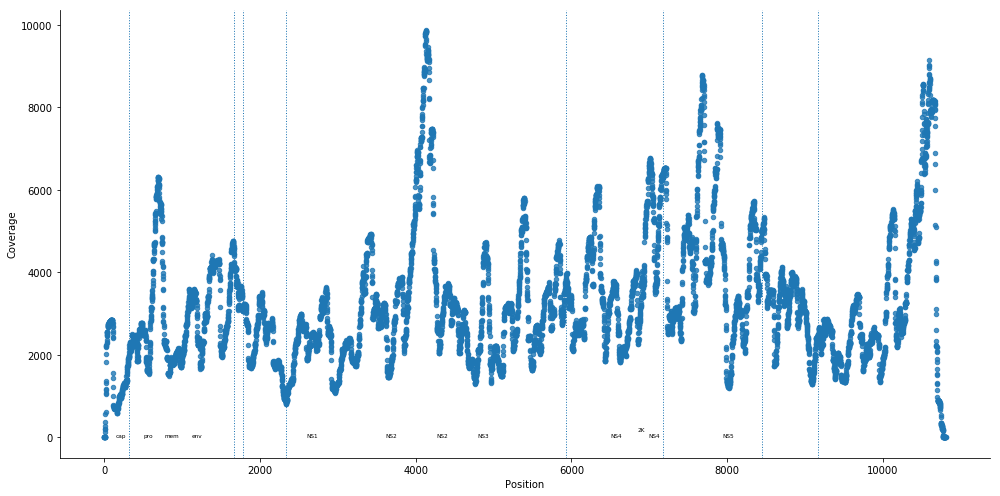

In [14]:
sns.lmplot( x="Position", y="Coverage", data=cirseq, fit_reg=False, legend=False, size=7, aspect=2, lowess=True,scatter_kws={"s": 20})
plt.legend(loc='lower right')
plot_positions()
plot_genes()

The coverage is very low.

### Frequency of the major base

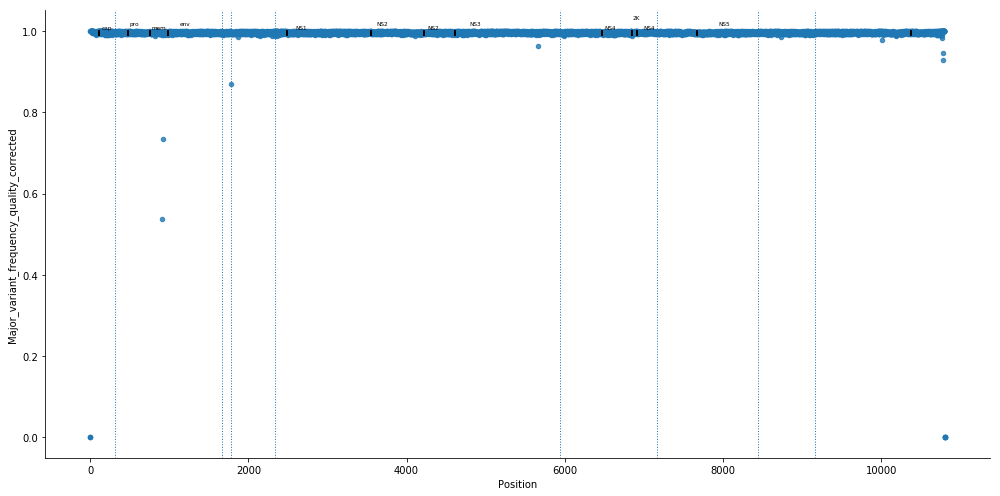

In [15]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=cirseq, fit_reg=False, legend=False, size=7, aspect=2, lowess=True,scatter_kws={"s": 20})
plt.legend(loc='lower right')
plot_positions()
plot_genes()

### Positions with frequency of the major variant below 0.95:

In [16]:
cirseq['Position'][cirseq['Major_variant_frequency_quality_corrected']<0.95]

0            0
1            1
2            2
910        910
926        926
1785      1785
10776    10776
10779    10779
10801    10801
10802    10802
10803    10803
10804    10804
10805    10805
10806    10806
Name: Position, dtype: int64

There is already position 1785... What are its states?

In [17]:
print("Position 1785: ")
print ("Major variant: "+cirseq['Major_variant'][1785])
print ("Second variant: "+cirseq['Second_variant'][1785])
print ("Major variant, aa: "+cirseq['consensus_aa'][1785])
print ("Second variant, aa: "+cirseq['secondbase_aa'][1785])

print("Frequency of the major variant: "+str(cirseq['Major_variant_frequency_quality_corrected'][1785]))
print("Frequency of the second variant: "+str(cirseq['Second_variant_frequency_quality_corrected'][1785]))


Position 1785: 
Major variant: C
Second variant: T
Major variant, aa: A
Second variant, aa: V
Frequency of the major variant: 0.870546
Frequency of the second variant: 0.125279


### Plot of the diversity in the Cirseq experiment

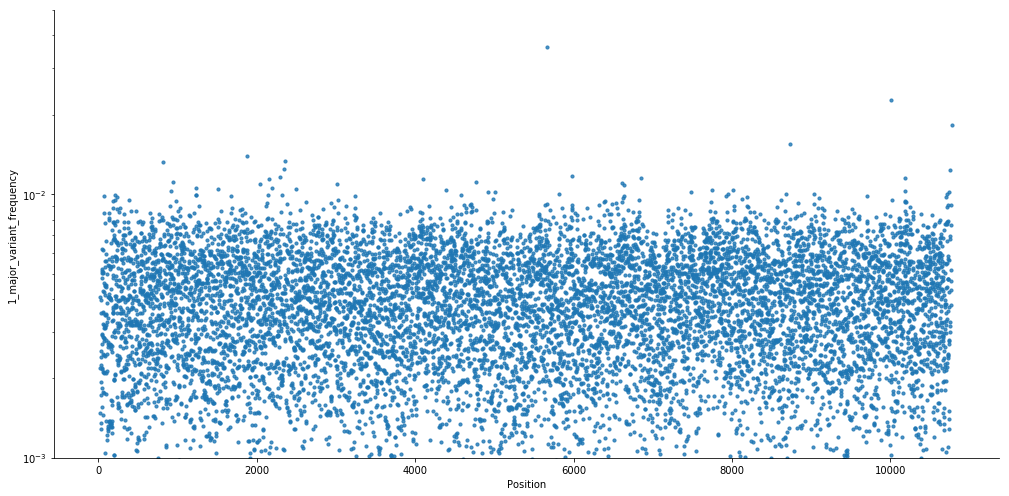

In [18]:
cirseq['1_major_variant_frequency'] = 1.0 - cirseq['Major_variant_frequency_quality_corrected']

#f, ax = plt.subplots(figsize=(10, 7))
#ax.set(yscale="log")

lm=sns.lmplot( x="Position", y="1_major_variant_frequency", data=cirseq, fit_reg=False, legend=False, size=7, aspect=2, scatter_kws={"s": 10})
axes = lm.axes
axes[0,0].set_ylim(0.001,0.05)
axes[0,0].set(yscale="log")

plt.legend(loc='lower right')

Here the distribution of diversity seems unimodal.

# Comparison with and without reamplification

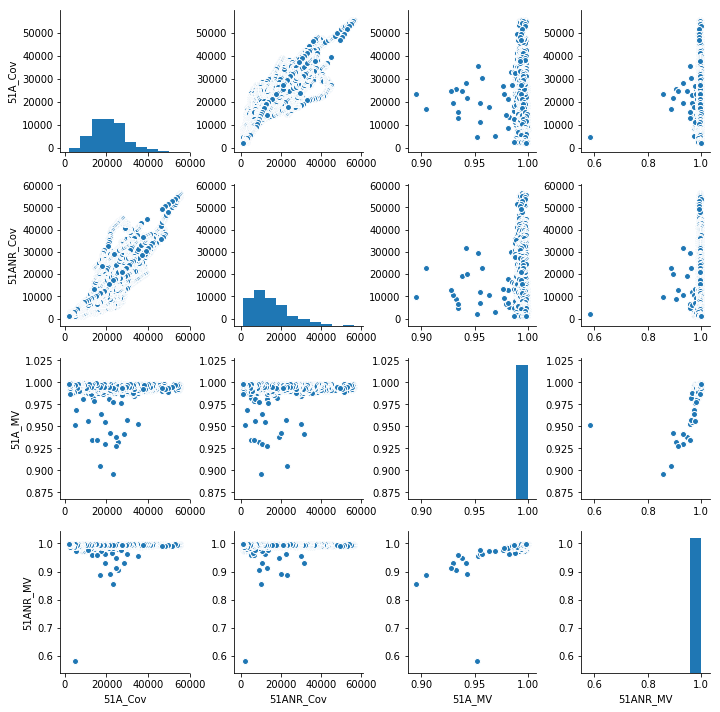

In [19]:

table_for_correlations = pd.DataFrame ({'51A_Cov':DD51_A ['Coverage'],'51ANR_Cov':DD51_A_no_reamp['Coverage'], '51A_MV':DD51_A ['Major_variant_frequency_quality_corrected'], '51ANR_MV':DD51_A_no_reamp ['Major_variant_frequency_quality_corrected'] })
table_for_correlations_highCov = table_for_correlations.loc[ (table_for_correlations['51A_Cov'] > 1000) & (table_for_correlations['51ANR_Cov'] > 1000) ]

sns.pairplot(table_for_correlations_highCov, vars=['51A_Cov','51ANR_Cov','51A_MV','51ANR_MV'], kind="scatter")

### Focus on the correlation between major variant frequencies

LinregressResult(slope=0.92080042757889113, intercept=0.078620806030560431, rvalue=0.55404367334663751, pvalue=0.0, stderr=0.013313968229028231)


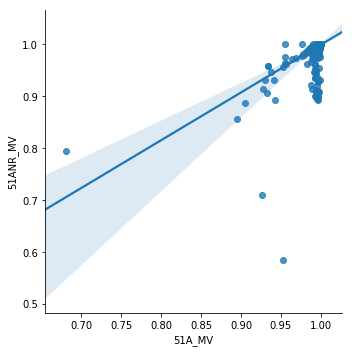

In [20]:
table_for_correlations_highFreq = table_for_correlations.loc[ (table_for_correlations['51A_MV'] > 0.1) & (table_for_correlations['51ANR_MV'] > 0.1) ]


lm=sns.lmplot(x='51A_MV',y='51ANR_MV', data=table_for_correlations_highFreq)
axes = lm.axes
#axes[0,0].set_ylim(0.001,0.05)

#axes[0,0].set(yscale="log", xscale="log")
res=linregress(table_for_correlations_highFreq['51A_MV'], table_for_correlations_highFreq['51ANR_MV'])
print(res)

There is a correlation between the frequencies of the major variants in the two libraries, but the correlation coefficient is not great (0.55). 

### Focus on those with frequency >0.9 in the sample with reamplification

LinregressResult(slope=0.77600804175089222, intercept=0.22278502849188975, rvalue=0.48967318178798563, pvalue=0.0, stderr=0.013302675626933793)


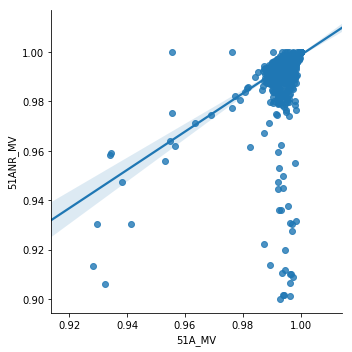

In [21]:

table_for_correlations_highFreq = table_for_correlations.loc[ (table_for_correlations['51ANR_MV'] > 0.9)  ]

lm=sns.lmplot(x='51A_MV',y='51ANR_MV', data=table_for_correlations_highFreq)
axes = lm.axes
#axes[0,0].set_ylim(0.001,0.05)

#axes[0,0].set(yscale="log")
res=linregress(table_for_correlations_highFreq['51A_MV'], table_for_correlations_highFreq['51ANR_MV'])
print(res)

The correlation is not great for positions where there is little variation. It is also surprising to see that lots of positions with frequencies between 0.9 and 1.0 in the non-reamplified library have a frequency of nearly 1.0 in the reamplified one. This seems to suggest that the amplification by PCR overly amplified the dominant variant in lots of cases.

### Correlation between second most frequent variants

In [22]:
table_for_correlations = pd.DataFrame ({'51A_Cov':DD51_A ['Coverage'],'51ANR_Cov':DD51_A_no_reamp['Coverage'], '51A_SV':DD51_A ['Second_variant_frequency_quality_corrected'], '51ANR_SV':DD51_A_no_reamp ['Second_variant_frequency_quality_corrected'] })
table_for_correlations_highCov = table_for_correlations.loc[ (table_for_correlations['51A_Cov'] > 1000) & (table_for_correlations['51ANR_Cov'] > 1000) ]


LinregressResult(slope=1.0931256196492429, intercept=-0.00037973675091814828, rvalue=0.6325437149737615, pvalue=0.0, stderr=0.012948740114485434)


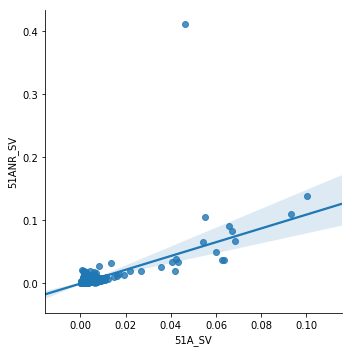

In [23]:

#table_for_correlations_highFreq = table_for_correlations.loc[ (table_for_correlations['51A_MV'] > 0.95)  ]

lm=sns.lmplot(x='51A_SV',y='51ANR_SV', data=table_for_correlations_highCov)
axes = lm.axes
#axes[0,0].set_ylim(0.001,0.05)

#axes[0,0].set(yscale="log")
res=linregress(table_for_correlations_highCov['51A_SV'], table_for_correlations_highCov['51ANR_SV'])
print(res)

The correlation between the frequencies of the second most frequent variants is not too bad (correlation coefficient 0.63). 

### Positions that differ in their most frequent base, and in their second most frequent base

Positions that differ in the most frequent base:

In [24]:
DD51_A ['Position'][DD51_A ['Major_variant'] != DD51_A_no_reamp ['Major_variant']]

3          3
4          4
5          5
2340    2340
Name: Position, dtype: int64

Number of positions that differ in the second most frequent base:

In [25]:
len(DD51_A ['Position'][DD51_A ['Second_variant'] != DD51_A_no_reamp ['Second_variant']])

1114

### Frequencies of the variants that change between the two library preparations

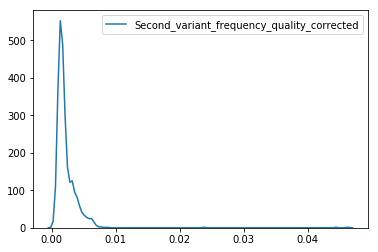

In [26]:
sns.kdeplot(DD51_A ['Second_variant_frequency_quality_corrected'][DD51_A ['Second_variant'] != DD51_A_no_reamp ['Second_variant']])

In [27]:
(DD51_A ['Second_variant_frequency_quality_corrected'][DD51_A ['Second_variant'] != DD51_A_no_reamp ['Second_variant']]).describe()

count    1114.000000
mean        0.002228
std         0.002332
min         0.000239
25%         0.001260
50%         0.001690
75%         0.002630
max         0.046251
Name: Second_variant_frequency_quality_corrected, dtype: float64

The second most frequent variants that differ between with and without reamplification usually have a low frequency; for frequent variants, the correlation is not too bad.

### Analysis of the diversity at time point 24 with or without reamplification

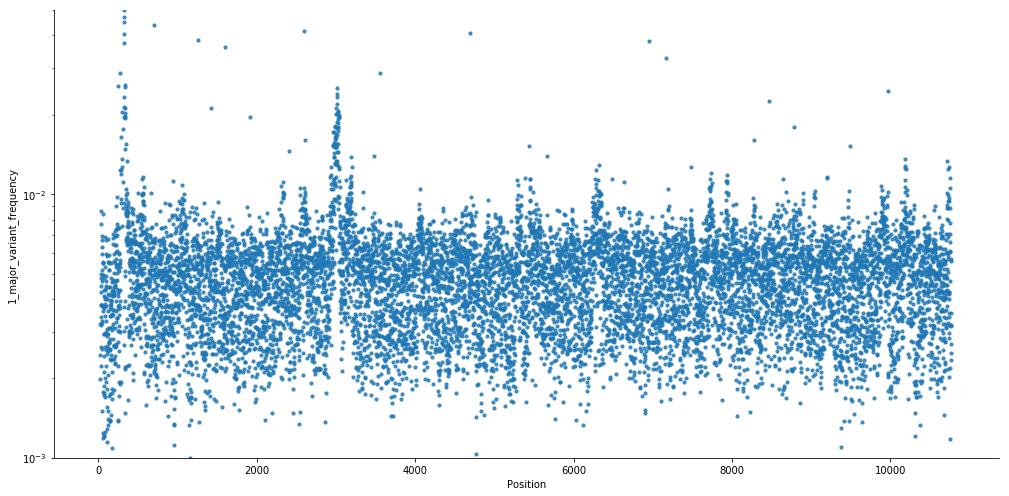

In [28]:
DD51_A_no_reamp['1_major_variant_frequency'] = 1.0 - DD51_A_no_reamp['Major_variant_frequency_quality_corrected']

#f, ax = plt.subplots(figsize=(10, 7))
#ax.set(yscale="log")

lm=sns.lmplot( x="Position", y="1_major_variant_frequency", data=DD51_A_no_reamp, fit_reg=False, legend=False, size=7, aspect=2, scatter_kws={"s": 10})
axes = lm.axes
axes[0,0].set_ylim(0.001,0.05)
axes[0,0].set(yscale="log")

plt.legend(loc='lower right')

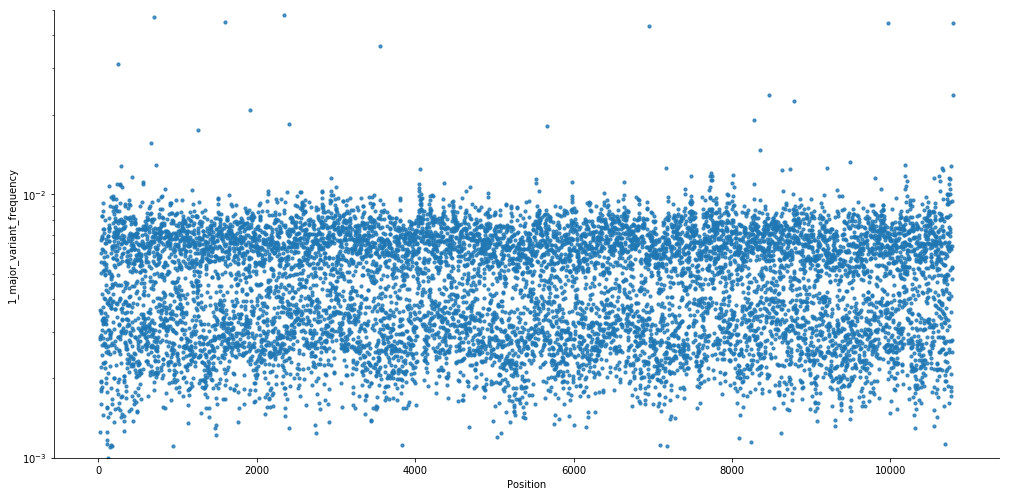

In [29]:
DD51_A['1_major_variant_frequency'] = 1.0 - DD51_A['Major_variant_frequency_quality_corrected']

#f, ax = plt.subplots(figsize=(10, 7))
#ax.set(yscale="log")

lm=sns.lmplot( x="Position", y="1_major_variant_frequency", data=DD51_A, fit_reg=False, legend=False, size=7, aspect=2, scatter_kws={"s": 10})
axes = lm.axes
axes[0,0].set_ylim(0.001,0.05)
axes[0,0].set(yscale="log")

plt.legend(loc='lower right')

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


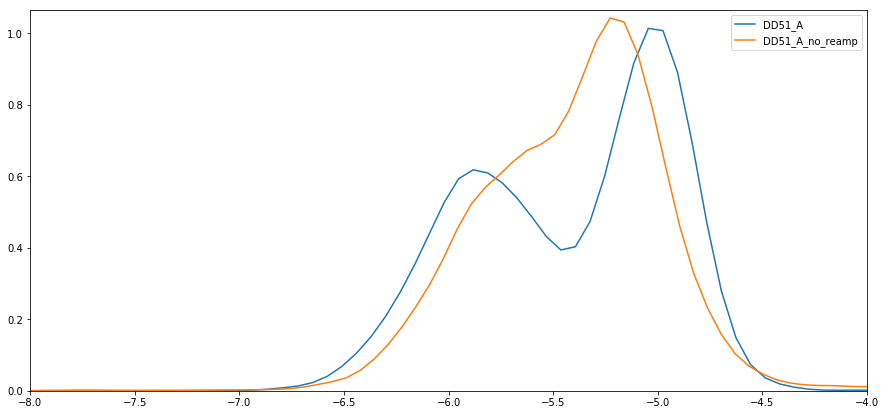

In [30]:
f, ax = plt.subplots(figsize=(15, 7))


lm=sns.kdeplot(np.log(DD51_A["1_major_variant_frequency"]), label="DD51_A")

axes = lm.axes
axes.set_xlim(-8,-4)

lm=sns.kdeplot(np.log(DD51_A_no_reamp["1_major_variant_frequency"]), label="DD51_A_no_reamp")


# Positions that increase in frequency

### Control, replicate A

In [31]:
tables_A = [DD3_A, DD6_A, DD9_A, DD12_A, DD24_A, DD51_A]
increasing_A = get_increasing_variants(tables_A)
print("There are "+str(len(increasing_A))+" positions that rise in frequency.")
print("Those are:")
print(increasing_A.keys())

There are 94 positions that rise in frequency.
Those are:
dict_keys([53, 55, 138, 165, 173, 316, 332, 357, 491, 824, 901, 1124, 1471, 1500, 1552, 1670, 1785, 1883, 1951, 2039, 2101, 2102, 2235, 2340, 2541, 2702, 2783, 2792, 2804, 2811, 3087, 3118, 3122, 3129, 3563, 3604, 4001, 4077, 4099, 4307, 4417, 4421, 4783, 4837, 4900, 4904, 5010, 5170, 5293, 5321, 5536, 5537, 5542, 5553, 5696, 5782, 5817, 5880, 5901, 6397, 6424, 6459, 6525, 6724, 6735, 6751, 6804, 6866, 6891, 6993, 7251, 7305, 7338, 8219, 8449, 8466, 8826, 8850, 8952, 9079, 9142, 9251, 9297, 9607, 9978, 10025, 10153, 10360, 10405, 10433, 10457, 10618, 10630, 10633])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


### Control, replicate D

In [32]:
tables_D = [DD3_D, DD6_D, DD9_D, DD12_D, DD24_D]
increasing_D = get_increasing_variants(tables_D)
print("There are "+str(len(increasing_D))+" positions that rise in frequency.")
print("Those are:")
print(increasing_D.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


There are 321 positions that rise in frequency.
Those are:
dict_keys([40, 138, 164, 176, 188, 207, 243, 254, 263, 295, 298, 433, 466, 531, 533, 535, 548, 570, 599, 664, 703, 731, 740, 796, 860, 957, 997, 1001, 1110, 1118, 1179, 1284, 1305, 1346, 1355, 1373, 1390, 1434, 1501, 1545, 1556, 1623, 1635, 1748, 1784, 1809, 1916, 1937, 1968, 1973, 2042, 2044, 2048, 2069, 2086, 2094, 2105, 2107, 2121, 2185, 2187, 2200, 2233, 2244, 2249, 2280, 2287, 2288, 2361, 2375, 2402, 2406, 2426, 2427, 2433, 2435, 2446, 2450, 2474, 2510, 2511, 2518, 2521, 2526, 2534, 2572, 2607, 2698, 2707, 2735, 2754, 2757, 2804, 2816, 2820, 2824, 2828, 2833, 2834, 2843, 2919, 2925, 2930, 2973, 2989, 2991, 3014, 3039, 3080, 3123, 3242, 3274, 3381, 3391, 3397, 3523, 3541, 3546, 3595, 3628, 3722, 3729, 3738, 3743, 3754, 3837, 3872, 3883, 3926, 3942, 3968, 3976, 4018, 4062, 4116, 4160, 4164, 4168, 4179, 4181, 4190, 4197, 4201, 4209, 4221, 4273, 4355, 4475, 4483, 4536, 4537, 4576, 4606, 4634, 4706, 4799, 4818, 4879, 4881, 4913

### Control, replicate E

In [33]:
tables_E = [DD6_E, DD9_E]
increasing_E = get_increasing_variants(tables_E)
print("There are "+str(len(increasing_E))+" positions that rise in frequency.")
print("There are too many of them, we choose not to print them.")

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


There are 6384 positions that rise in frequency.
There are too many of them, we choose not to print them.


### TLR3 treatment

In [34]:
tables_TA = [TD9_A, TD12_A, TD24_A, TD51_A]
increasing_TA = get_increasing_variants(tables_TA)
print("There are "+str(len(increasing_TA))+" positions that rise in frequency.")
print("Those are:")
print(increasing_TA.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


There are 241 positions that rise in frequency.
Those are:
dict_keys([84, 137, 146, 158, 168, 226, 233, 269, 285, 305, 415, 461, 486, 487, 520, 580, 628, 629, 647, 649, 719, 752, 832, 856, 877, 916, 917, 919, 941, 958, 974, 1003, 1028, 1085, 1088, 1121, 1137, 1149, 1181, 1205, 1319, 1321, 1328, 1339, 1344, 1392, 1403, 1445, 1524, 1525, 1546, 1618, 1620, 1622, 1633, 1745, 1747, 1750, 1756, 1785, 1874, 1888, 2117, 2193, 2243, 2265, 2309, 2356, 2373, 2409, 2425, 2428, 2435, 2442, 2472, 2492, 2495, 2503, 2598, 2609, 2720, 2733, 2864, 2873, 2950, 3007, 3145, 3258, 3300, 3417, 3482, 3547, 3553, 3608, 3641, 3644, 3658, 3696, 3709, 3746, 3797, 3805, 3831, 3837, 3890, 3904, 4084, 4288, 4302, 4347, 4360, 4363, 4474, 4502, 4564, 4606, 4797, 4824, 4836, 4842, 4849, 4897, 4900, 4925, 4974, 5032, 5056, 5108, 5186, 5252, 5278, 5307, 5332, 5449, 5494, 5675, 5691, 5747, 5821, 5848, 5887, 5934, 5935, 6032, 6037, 6087, 6317, 6505, 6551, 6553, 6562, 6588, 6593, 6682, 6691, 6701, 6708, 6737, 6760, 6793, 68

## Plotting only positions that consistently rise in frequency, control, replicate A

Here we plot the frequency of the major variant at day 51 in the control experiment, A. We color the dots according to whether they were consistently rising in frequency or not.

In [35]:
sns.set_palette("hls")
sns.set_context("poster")

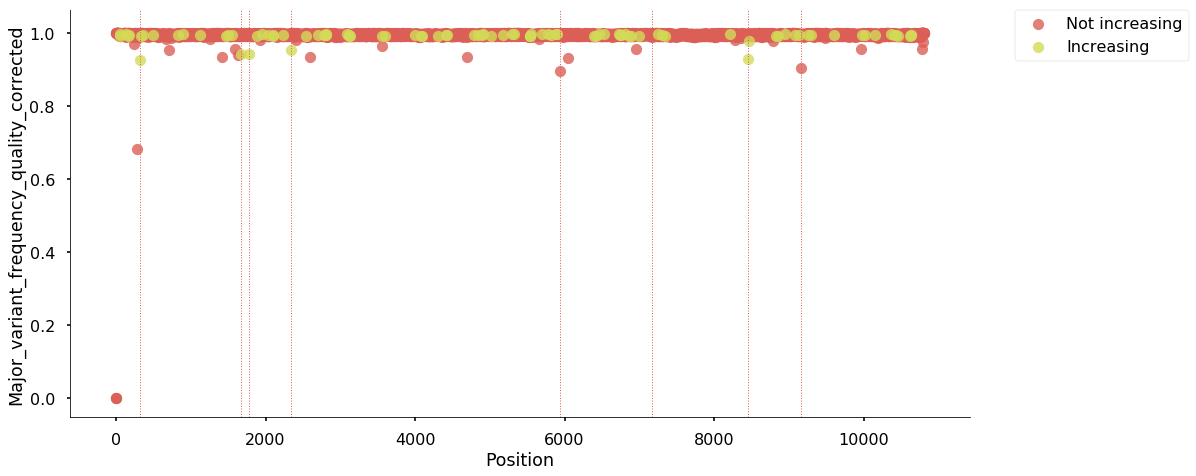

In [36]:
increasing_A_keys = increasing_A.keys()
is_increasing = []
for i in DD51_A['Position']:
    if i in increasing_A_keys:
        is_increasing.append("Increasing")
    else:
        is_increasing.append("Not increasing")
to_plot = pd.DataFrame ({'Position':DD51_A['Position'], 'Major_variant_frequency_quality_corrected':DD51_A ['Major_variant_frequency_quality_corrected'],'Is_increasing':is_increasing}) 
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=to_plot, fit_reg=False, hue='Is_increasing', legend=False, size=7, aspect=2)
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot_positions()
#plot_genes()

## Increase per consistently increasing position

Here we plot the increase in frequency of the second variant, over the course of the entire  experiment, in the different replicates.

In [37]:
def plot_increase_per_increasing_position (increasing_list, last_table):
    increasing_list_keys = increasing_list.keys()
    increase = []
    is_increasing = []
    for i in last_table['Position']:
        if i in increasing_list_keys:
            increase.append(increasing_list[i][1][len(increasing_list[i][1])-1] - increasing_list[i][1][0])
            is_increasing.append("Increasing")
        else:
            increase.append(0.0)
            is_increasing.append("Not increasing")
    to_plot = pd.DataFrame ({'Position':last_table['Position'], 'Increase':increase,'Is_increasing':is_increasing}) 
    sns.lmplot( x="Position", y="Increase", data=to_plot, fit_reg=False, hue='Is_increasing', legend=False, size=7, aspect=2)
#    plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()
    #plot_genes()
    return


### Control, replicate A

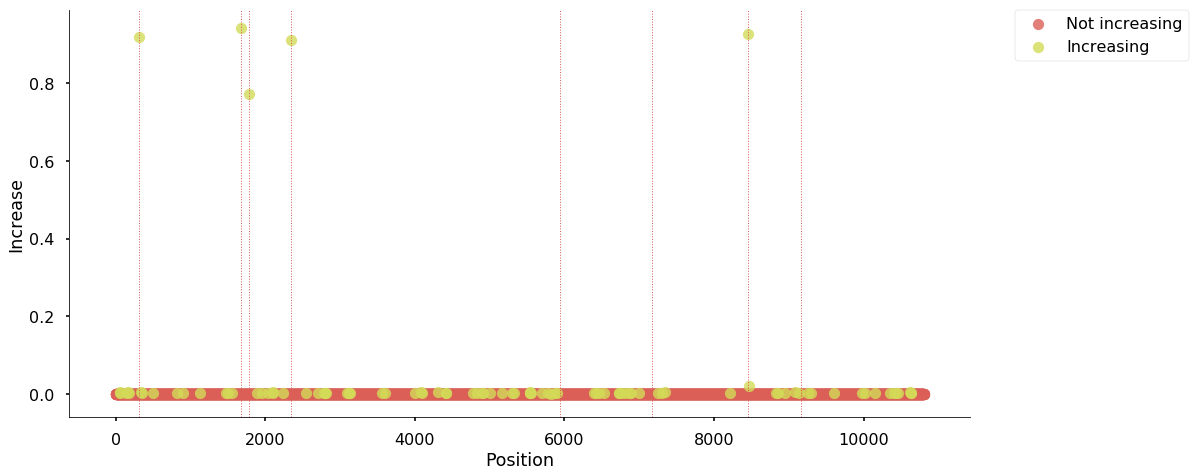

In [38]:
plot_increase_per_increasing_position (increasing_A, DD51_A)

### Control, replicate D:

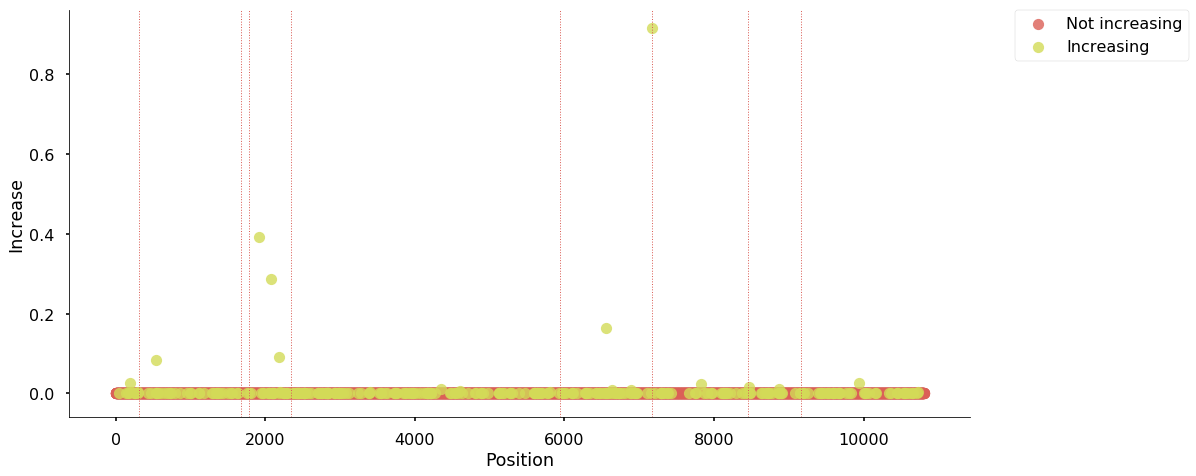

In [39]:
plot_increase_per_increasing_position (increasing_D, DD24_D)

### Control, replicate E (not to be trusted: only two time points):

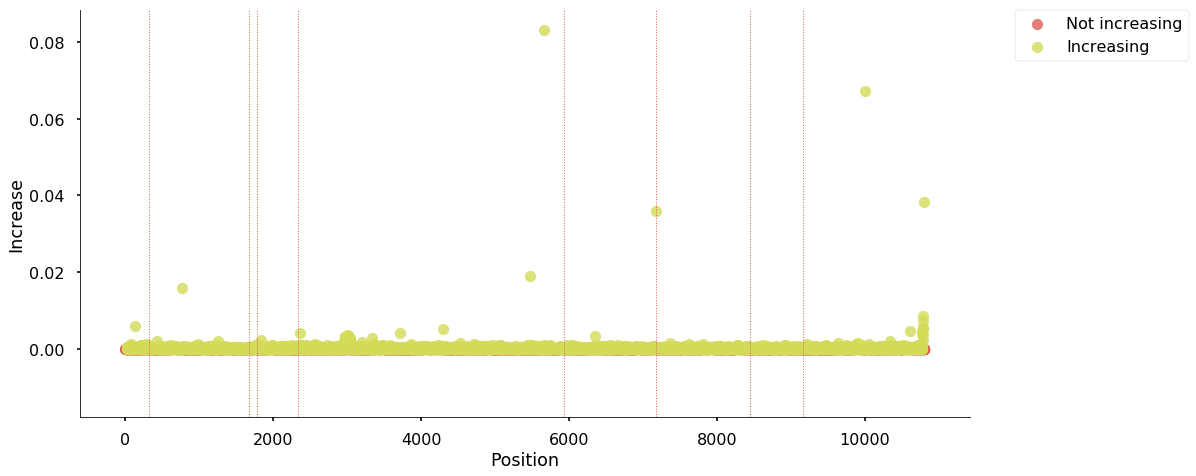

In [40]:
plot_increase_per_increasing_position (increasing_E, DD9_E)

### TLR3 treatment:

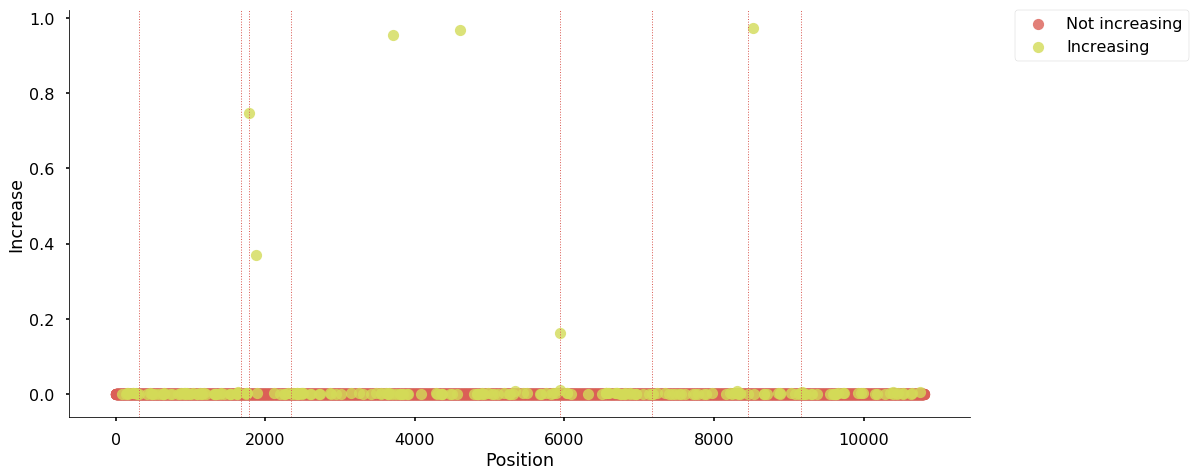

In [41]:
plot_increase_per_increasing_position (increasing_TA, TD51_A)

# Plots overlaying different time points

Here we plot the frequencies of the major variants, for the different time points of an experiment.

In [42]:
overlay_table =  pd.DataFrame ({'Position':DD3_A['Position'], 'DD3_A':DD3_A ['Major_variant_frequency_quality_corrected'], 'DD6_A':DD6_A ['Major_variant_frequency_quality_corrected'],'DD9_A':DD9_A ['Major_variant_frequency_quality_corrected'],'DD12_A':DD12_A ['Major_variant_frequency_quality_corrected'], 'DD24_A':DD24_A ['Major_variant_frequency_quality_corrected'], 'DD51_A':DD51_A ['Major_variant_frequency_quality_corrected']})
siz = len(DD3_A ['Position'])
sample = siz*["DD3A"]+siz*["DD6A"]+siz*["DD9A"]+siz*["DD12A"]+siz*["DD24A"]+siz*["DD51A"]

overlay_table_concat = pd.DataFrame ({'Position':pd.concat([DD3_A['Position'],DD6_A['Position'],DD9_A['Position'],DD12_A['Position'],DD24_A['Position'],DD51_A['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD3_A ['Major_variant_frequency_quality_corrected'],DD6_A ['Major_variant_frequency_quality_corrected'], DD9_A ['Major_variant_frequency_quality_corrected'],DD12_A ['Major_variant_frequency_quality_corrected'], DD24_A ['Major_variant_frequency_quality_corrected'], DD51_A ['Major_variant_frequency_quality_corrected'] ]), 'sample':sample})



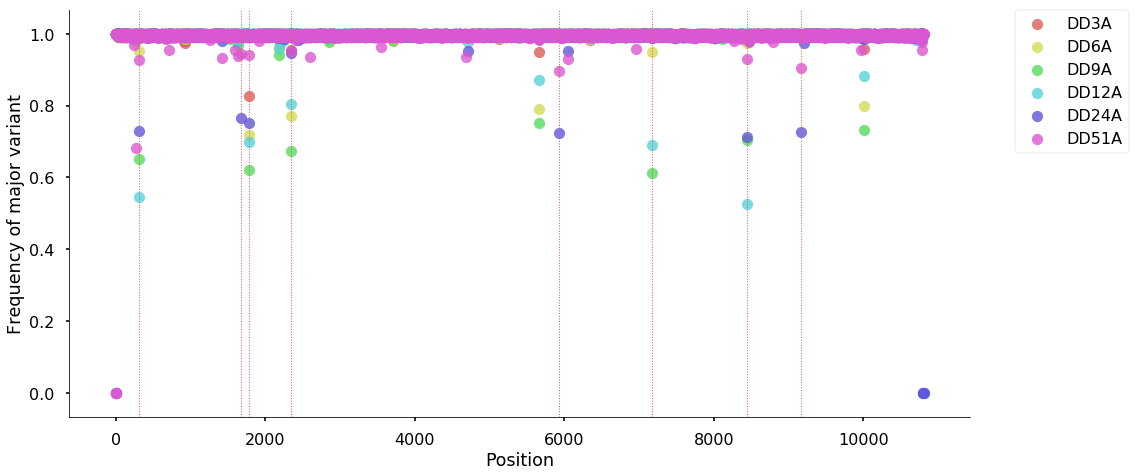

In [43]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Frequency of major variant")
plot_positions()
#plot_genes()

Same thing, smaller dots

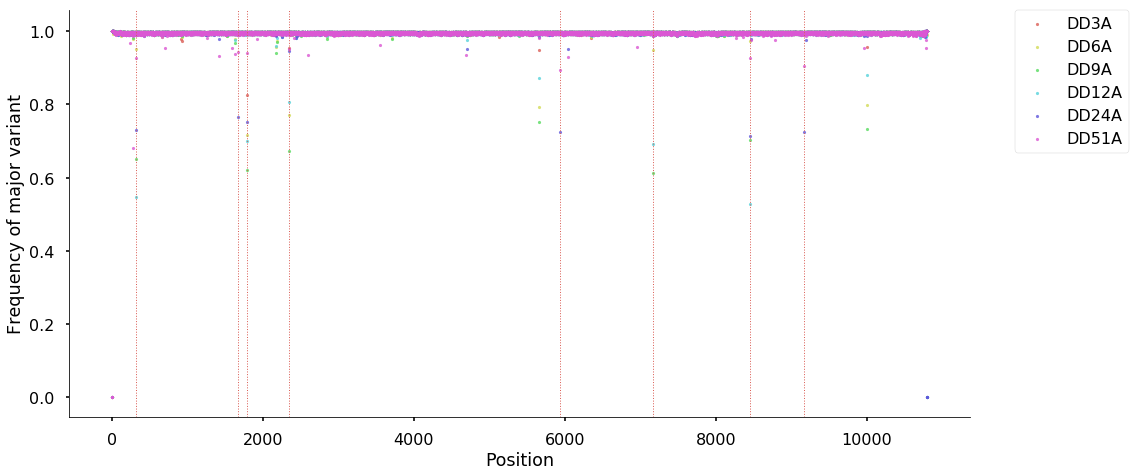

In [44]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, scatter_kws={"s": 10})
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Frequency of major variant")

plot_positions()
#plot_genes()

## Same thing, without sample at 51 days

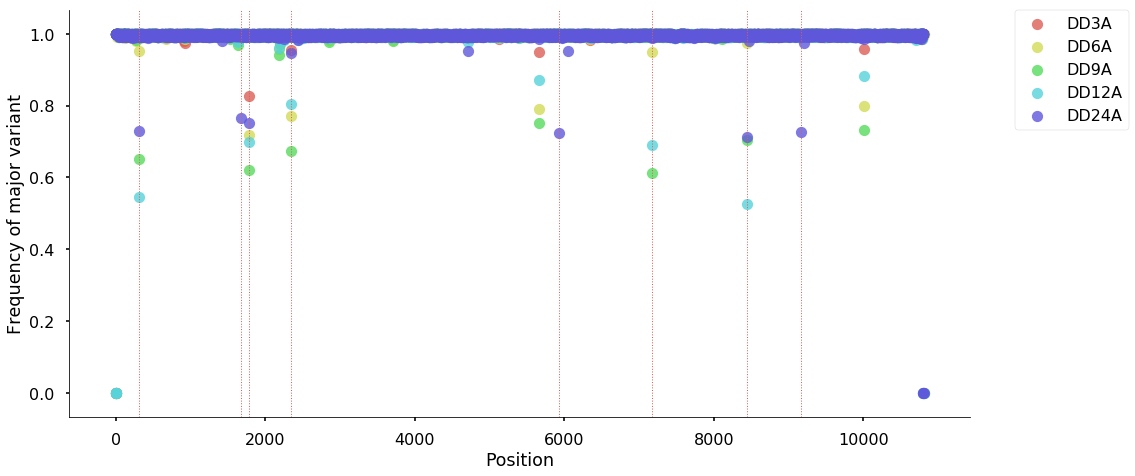

In [45]:
overlay_table_concat_no51 = overlay_table_concat.loc[overlay_table_concat['sample']!= "DD51A"]
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data= overlay_table_concat_no51, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Frequency of major variant")

plot_positions()
#plot_genes()

# Difference in frequency between day 3 and day 51?

Here we want to know if over all positions, the diversity has increased between day 3 and day 51. 

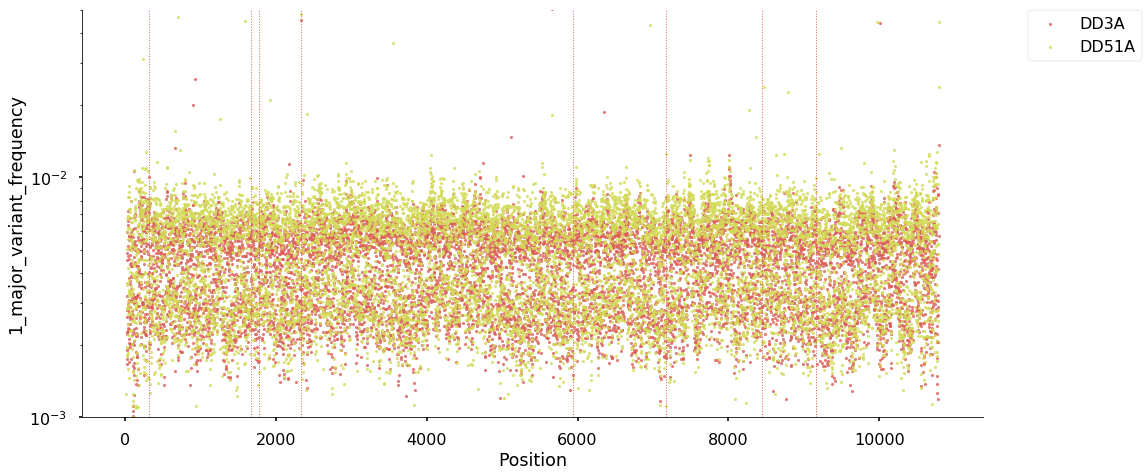

In [46]:
overlay_table_concat['1_major_variant_frequency'] = 1.0 - overlay_table_concat['Major_variant_frequency_quality_corrected']

#f, ax = plt.subplots(figsize=(10, 7))
#ax.set(yscale="log")

overlay_table_concat_nointer = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD6A")]
lm=sns.lmplot( x="Position", y="1_major_variant_frequency", data=overlay_table_concat_nointer, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, scatter_kws={"s": 10})
axes = lm.axes
axes[0,0].set_ylim(0.001,0.05)
axes[0,0].set(yscale="log")

#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot_positions()
#plot_genes()

## Day 3 only

[None]

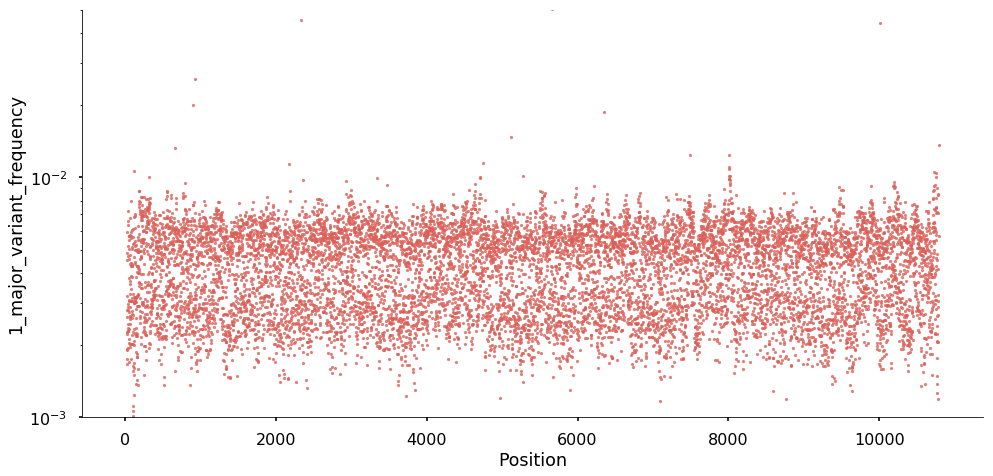

In [47]:
overlay_table_concat_nointer = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD51A") &(overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD6A")]
lm=sns.lmplot( x="Position", y="1_major_variant_frequency", data=overlay_table_concat_nointer, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, scatter_kws={"s": 10})
axes = lm.axes
axes[0,0].set_ylim(0.001,0.05)
axes[0,0].set(yscale="log")

#plt.legend(loc='lower right')
#plot_positions()
#plot_genes()

## Boxplot day 3-day 51

[ 0.004337  0.004941]
T-test p-value: 0.00235244161087
0.004337000000000035
0.004940999999999973


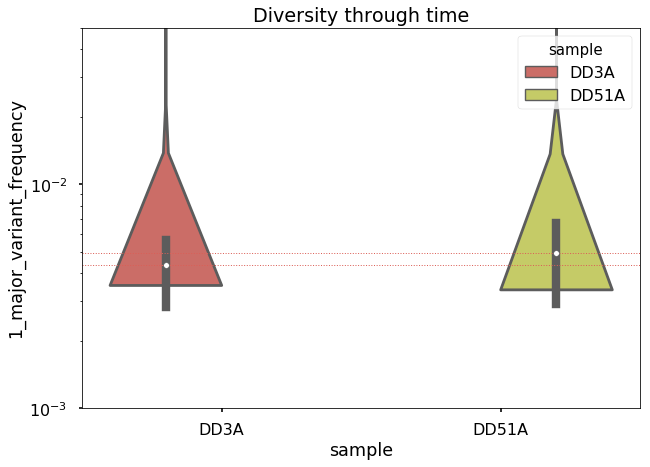

In [48]:
overlay_table_concat_nointer = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD6A")]
f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='sample', y="1_major_variant_frequency", data=overlay_table_concat_nointer,  hue='sample', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = overlay_table_concat_nointer.groupby(['sample'])['1_major_variant_frequency'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
print(medians)
syn = overlay_table_concat_nointer['1_major_variant_frequency'][overlay_table_concat_nointer['sample']=="DD3A"]
nonsyn = overlay_table_concat_nointer['1_major_variant_frequency'][overlay_table_concat_nointer['sample']=="DD51A"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))
print((syn).median())
print((nonsyn).median())
# giving title to the plot
plt.title("Diversity through time");


### Density (KDE) plot, control, replicate A

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


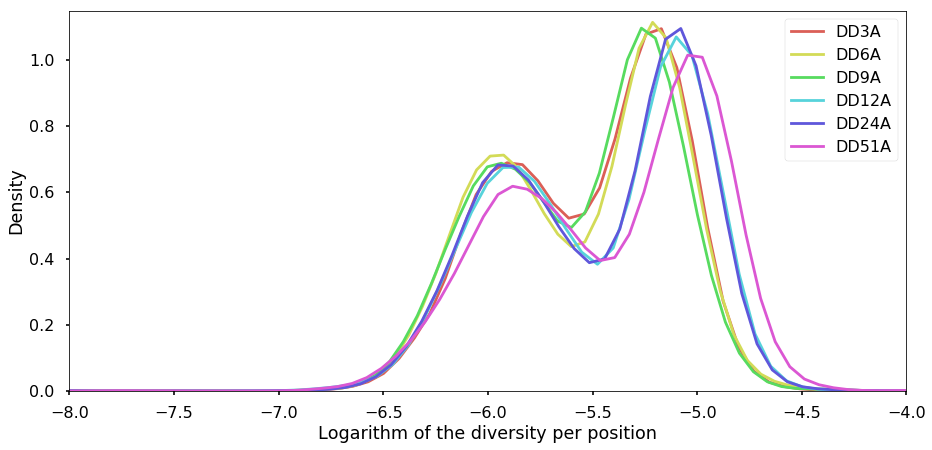

In [49]:
f, ax = plt.subplots(figsize=(15, 7))

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD51A") & (overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD6A")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD3A")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

axes = lm.axes
axes.set_xlim(-8,-4)

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD51A") & (overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD3A")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD6A")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD51A") & (overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD6A") & (overlay_table_concat['sample']!= "DD3A")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD9A")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD51A") & (overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD6A") & (overlay_table_concat['sample']!= "DD3A")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD12A")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD51A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD6A") & (overlay_table_concat['sample']!= "DD3A")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD24A")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD24A") & (overlay_table_concat['sample']!= "DD12A") & (overlay_table_concat['sample']!= "DD9A") & (overlay_table_concat['sample']!= "DD6A") & (overlay_table_concat['sample']!= "DD3A")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD51A")


### Density (KDE) plot, control, replicate D

In [50]:
overlay_table =  pd.DataFrame ({'Position':DD3_D['Position'], 'DD3_D':DD3_D ['Major_variant_frequency_quality_corrected'], 'DD6_D':DD6_D ['Major_variant_frequency_quality_corrected'],'DD9_D':DD9_D ['Major_variant_frequency_quality_corrected'],'DD12_D':DD12_D ['Major_variant_frequency_quality_corrected'], 'DD24_D':DD24_D ['Major_variant_frequency_quality_corrected']})
siz = len(DD3_D ['Position'])
sample = siz*["DD3D"]+siz*["DD6D"]+siz*["DD9D"]+siz*["DD12D"]+siz*["DD24D"]

overlay_table_concat = pd.DataFrame ({'Position':pd.concat([DD3_D['Position'],DD6_D['Position'],DD9_D['Position'],DD12_D['Position'],DD24_D['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD3_D ['Major_variant_frequency_quality_corrected'],DD6_D ['Major_variant_frequency_quality_corrected'], DD9_D ['Major_variant_frequency_quality_corrected'],DD12_D ['Major_variant_frequency_quality_corrected'], DD24_D ['Major_variant_frequency_quality_corrected'] ]), 'sample':sample})
overlay_table_concat["1_major_variant_frequency"] = 1-overlay_table_concat['Major_variant_frequency_quality_corrected']

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


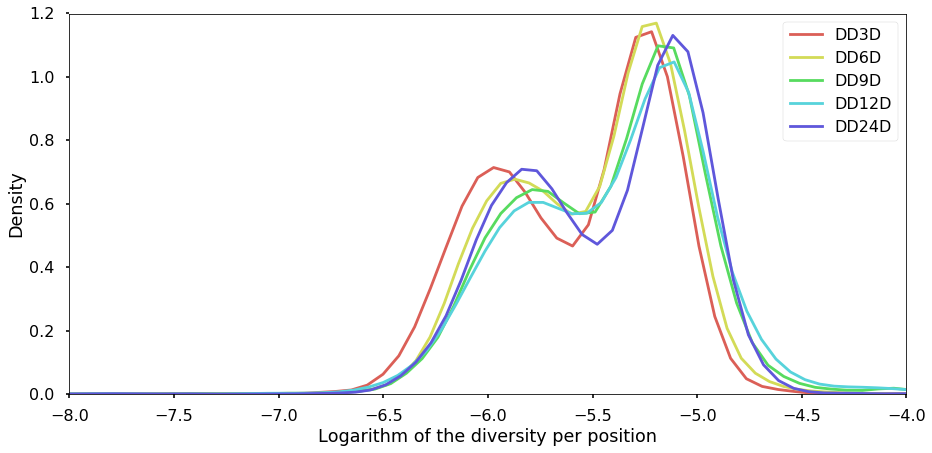

In [51]:
f, ax = plt.subplots(figsize=(15, 7))

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD24D") & (overlay_table_concat['sample']!= "DD12D") & (overlay_table_concat['sample']!= "DD9D") & (overlay_table_concat['sample']!= "DD6D")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD3D")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

axes = lm.axes
axes.set_xlim(-8,-4)

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD24D") & (overlay_table_concat['sample']!= "DD12D") & (overlay_table_concat['sample']!= "DD9D") & (overlay_table_concat['sample']!= "DD3D")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD6D")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD24D") & (overlay_table_concat['sample']!= "DD12D") & (overlay_table_concat['sample']!= "DD6D") & (overlay_table_concat['sample']!= "DD3D")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD9D")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD24D") & (overlay_table_concat['sample']!= "DD9D") & (overlay_table_concat['sample']!= "DD6D") & (overlay_table_concat['sample']!= "DD3D")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD12D")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "DD12D") & (overlay_table_concat['sample']!= "DD9D") & (overlay_table_concat['sample']!= "DD6D") & (overlay_table_concat['sample']!= "DD3D")]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="DD24D")



### Density (KDE) plot, TLR3 treatment

In [52]:
overlay_table =  pd.DataFrame ({'Position':TD9_A['Position'], 'TD9':TD9_A ['Major_variant_frequency_quality_corrected'], 'TD12':TD12_A ['Major_variant_frequency_quality_corrected'],'TD24':TD24_A ['Major_variant_frequency_quality_corrected'],'TD51':TD51_A ['Major_variant_frequency_quality_corrected'] })
siz = len(TD9_A ['Position'])
sample = siz*["TD9"]+siz*["TD12"]+siz*["TD24"]+siz*["TD51"]

overlay_table_concat = pd.DataFrame ({'Position':pd.concat([TD9_A['Position'], TD12_A['Position'], TD24_A['Position'], TD51_A['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([ TD9_A ['Major_variant_frequency_quality_corrected'], TD12_A ['Major_variant_frequency_quality_corrected'], TD24_A ['Major_variant_frequency_quality_corrected'], TD51_A ['Major_variant_frequency_quality_corrected'] ]), 'sample':sample})
overlay_table_concat["1_major_variant_frequency"] = 1-overlay_table_concat['Major_variant_frequency_quality_corrected']


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


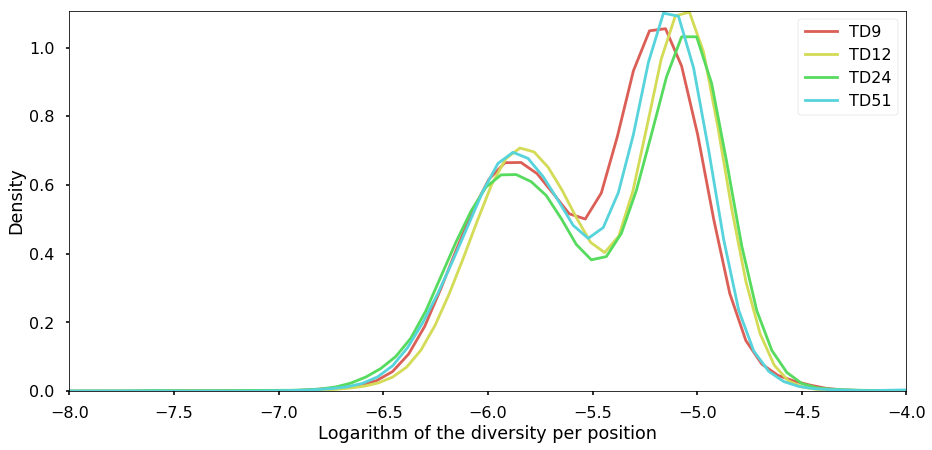

In [53]:

f, ax = plt.subplots(figsize=(15, 7))

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "TD12") & (overlay_table_concat['sample']!= "TD24") & (overlay_table_concat['sample']!= "TD51") ]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="TD9")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

axes = lm.axes
axes.set_xlim(-8,-4)

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "TD9") & (overlay_table_concat['sample']!= "TD24") & (overlay_table_concat['sample']!= "TD51") ]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="TD12")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "TD9") & (overlay_table_concat['sample']!= "TD12") & (overlay_table_concat['sample']!= "TD51") ]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="TD24")

temp = overlay_table_concat.loc[ (overlay_table_concat['sample']!= "TD9") & (overlay_table_concat['sample']!= "TD12") & (overlay_table_concat['sample']!= "TD24") ]
del temp['sample']
del temp['Major_variant_frequency_quality_corrected']
del temp['Position']
#print(temp.describe())
#ax = sns.kdeplot("1_major_variant_frequency", data=temp)
lm=sns.kdeplot(np.log(temp["1_major_variant_frequency"]), label="TD51")




In the analyses above, it would seem that the diversity, i.e. the amount of polymorphism, has increased a bit, as in Acevedo et al. 2014. However, presumably because we do not use Cirseq, we have a bimodal distribution of diversity, with possibly first a peak corresponding to sequencing errors, and second a peak corresponding to variants that do rise in frequency through time. In support of this hypothesis, the only CirSeq data we have, analyzed at the top of this document, does not show this bimodal distribution, and in the graphs above for the replicate A and the TLR3 treatment condition, only the variants with high frequency seem to increase in frequency through time. In the replicate D, it is not clear because the increase seems to be in both peaks.

## Diversity through time plot, replicate A

Here we do the same type of analysis, but looking at all time points, not just 3 and 51.

Median values of the diversity per sample:
sample
TD9     0.004507
TD12    0.004861
TD24    0.004768
TD51    0.004543
Name: 1_major_variant_frequency, dtype: float64
Mean values of the diversity per sample:
sample
TD9     0.004674
TD12    0.005343
TD24    0.004901
TD51    0.005073
Name: 1_major_variant_frequency, dtype: float64


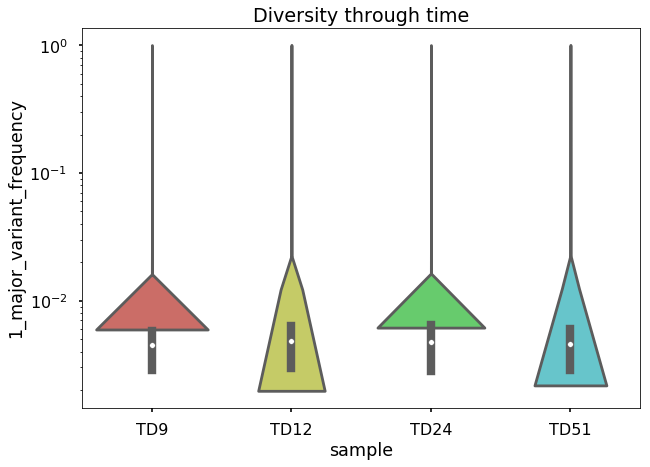

In [54]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
sns.violinplot(x='sample', y="1_major_variant_frequency", data=overlay_table_concat,  ax=ax, bw=0.2)

# giving title to the plot
plt.title("Diversity through time");

medians = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].median()
print("Median values of the diversity per sample:" )
print(medians)
means = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].mean()
print("Mean values of the diversity per sample:" )
print(means)


The increase is no longer obvious, certainly not monotonous. If anything, what might be happening is that first diversity decreases from time points 3 to 9, then increases. If this is true, this could be compatible with a selective sweep in the first days, so that only some haplotypes carrying the variants with the high fitness increase in frequency.

## Same thing, Sample D

In [55]:

overlay_table =  pd.DataFrame ({'Position':DD3_D['Position'], 'DD3_D':DD3_D ['Major_variant_frequency_quality_corrected'], 'DD6_D':DD6_D ['Major_variant_frequency_quality_corrected'],'DD9_D':DD9_D ['Major_variant_frequency_quality_corrected'],'DD12_D':DD12_D ['Major_variant_frequency_quality_corrected'],'DD24_D':DD24_D ['Major_variant_frequency_quality_corrected']})
siz = len(DD3_D ['Position'])
sample = siz*["DD3D"]+siz*["DD6D"]+siz*["DD9D"]+siz*["DD12D"]+siz*["DD24D"]

overlay_table_concat = pd.DataFrame ({'Position':pd.concat([DD3_D['Position'],DD6_D['Position'],DD9_D['Position'],DD12_D['Position'],DD24_D['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD3_D ['Major_variant_frequency_quality_corrected'],DD6_D ['Major_variant_frequency_quality_corrected'], DD9_D ['Major_variant_frequency_quality_corrected'],DD12_D ['Major_variant_frequency_quality_corrected'], DD24_D ['Major_variant_frequency_quality_corrected'] ]), 'sample':sample})

overlay_table_concat['1_major_variant_frequency'] = 1.0 - overlay_table_concat['Major_variant_frequency_quality_corrected']



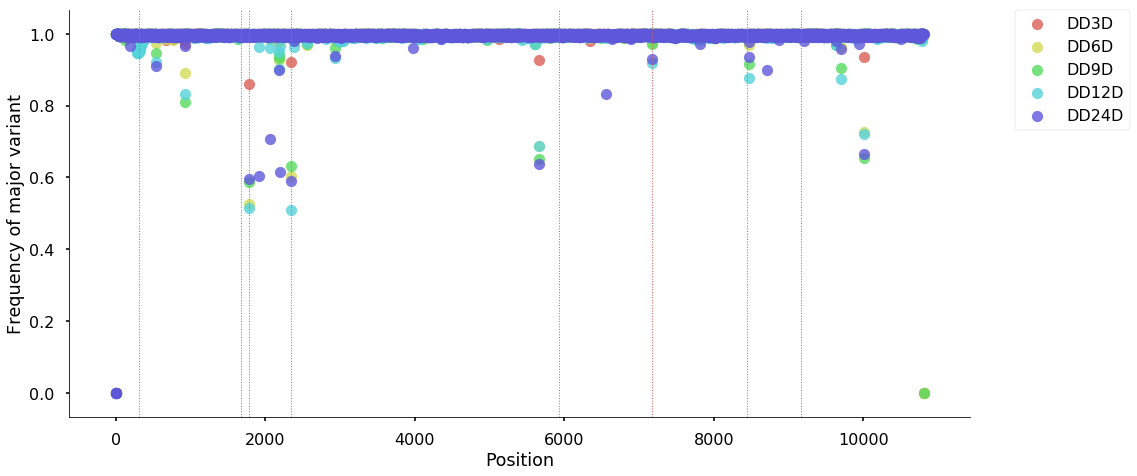

In [56]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Frequency of major variant")
plot_positions()
#plot_genes()

## Diversity through time plot, replicate D

Median values of the diversity per sample:
sample
DD3D     0.004186
DD6D     0.004450
DD9D     0.004750
DD12D    0.004845
DD24D    0.004713
Name: 1_major_variant_frequency, dtype: float64
Mean values of the diversity per sample:
sample
DD3D     0.004531
DD6D     0.004935
DD9D     0.005164
DD12D    0.005557
DD24D    0.005362
Name: 1_major_variant_frequency, dtype: float64


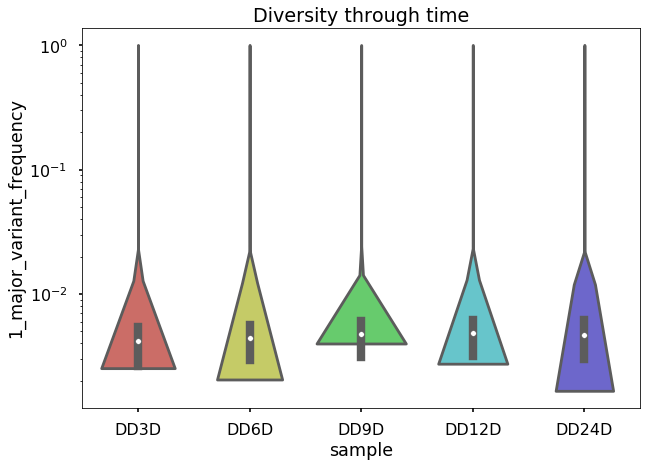

In [57]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
sns.violinplot(x='sample', y="1_major_variant_frequency", data=overlay_table_concat,  ax=ax, bw=0.2)

# giving title to the plot
plt.title("Diversity through time");

medians = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].median()
print("Median values of the diversity per sample:" )
print(medians)
means = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].mean()
print("Mean values of the diversity per sample:" )
print(means)


In this case, it may be that the diversity increases then reaches some sort of plateau at about a median of 0.0047-0.0048.

## Same thing, sample E

In [58]:
siz = len(DD6_E ['Position'])
sample = siz*["DD6E"]+siz*["DD9E"]

overlay_table_concat = pd.DataFrame ({'Position':pd.concat([DD6_E['Position'],DD9_E['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD6_E ['Major_variant_frequency_quality_corrected'],DD9_E ['Major_variant_frequency_quality_corrected']]), 'sample':sample})
overlay_table_concat['1_major_variant_frequency'] = 1.0 - overlay_table_concat['Major_variant_frequency_quality_corrected']


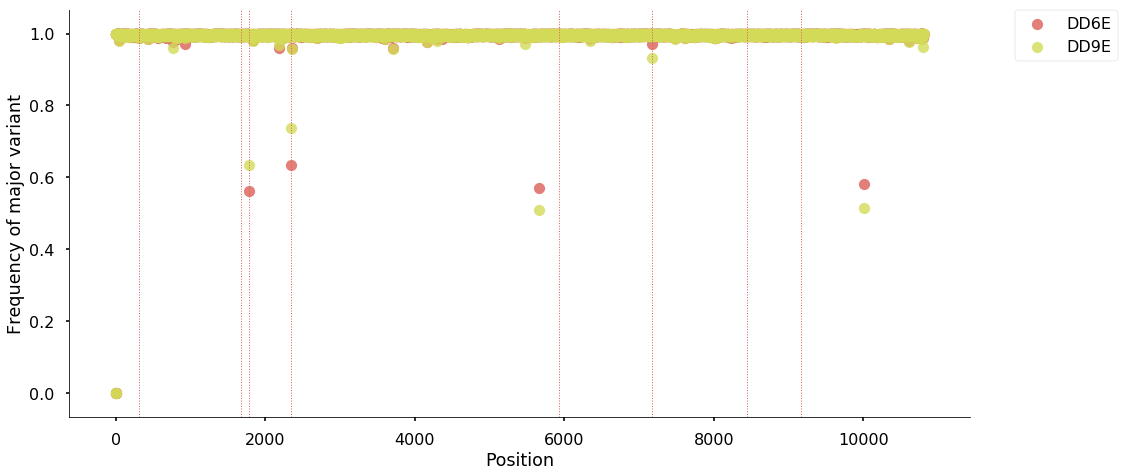

In [59]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
plt.ylabel("Frequency of major variant")
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot_positions()
#plot_genes()

## Diversity through time plot, replicate E

Median values of the diversity per sample:
sample
DD6E    0.004326
DD9E    0.004504
Name: 1_major_variant_frequency, dtype: float64
Mean values of the diversity per sample:
sample
DD6E    0.004740
DD9E    0.004837
Name: 1_major_variant_frequency, dtype: float64


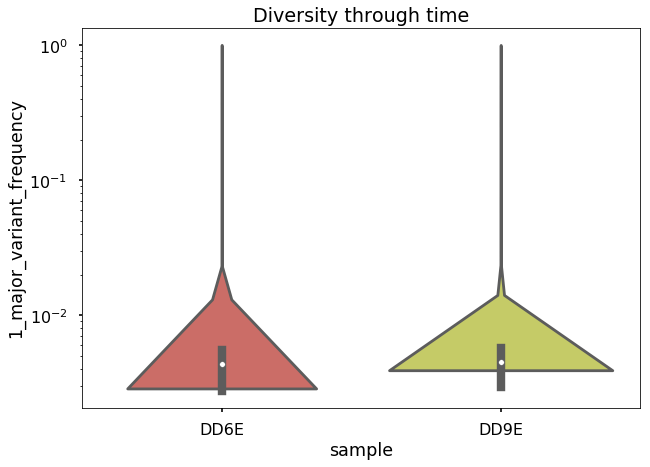

In [60]:

f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
sns.violinplot(x='sample', y="1_major_variant_frequency", data=overlay_table_concat,  ax=ax, bw=0.2)

# giving title to the plot
plt.title("Diversity through time");

medians = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].median()
print("Median values of the diversity per sample:" )
print(medians)
means = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].mean()
print("Mean values of the diversity per sample:" )
print(means)

Although we only have two time points, the results are consistent with an increase in the first few days.

## Same thing, TLR3 activation

In [61]:
overlay_table =  pd.DataFrame ({'Position':TD9_A['Position'], 'TD9_A':TD9_A ['Major_variant_frequency_quality_corrected'], 'TD12_A':TD12_A ['Major_variant_frequency_quality_corrected'],'TD24_A':TD24_A ['Major_variant_frequency_quality_corrected'], 'TD51_A':TD51_A ['Major_variant_frequency_quality_corrected']})
siz = len(TD9_A ['Position'])
sample = siz*["TD9A"]+siz*["TD12A"]+siz*["TD24A"]+siz*["TD51A"]

overlay_table_concat = pd.DataFrame ({'Position':pd.concat([TD9_A['Position'],TD12_A['Position'],TD24_A['Position'],TD51_A['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([TD9_A['Major_variant_frequency_quality_corrected'],TD12_A['Major_variant_frequency_quality_corrected'],TD24_A['Major_variant_frequency_quality_corrected'],TD51_A['Major_variant_frequency_quality_corrected'] ]), 'sample':sample})
overlay_table_concat['1_major_variant_frequency'] = 1.0 - overlay_table_concat['Major_variant_frequency_quality_corrected']



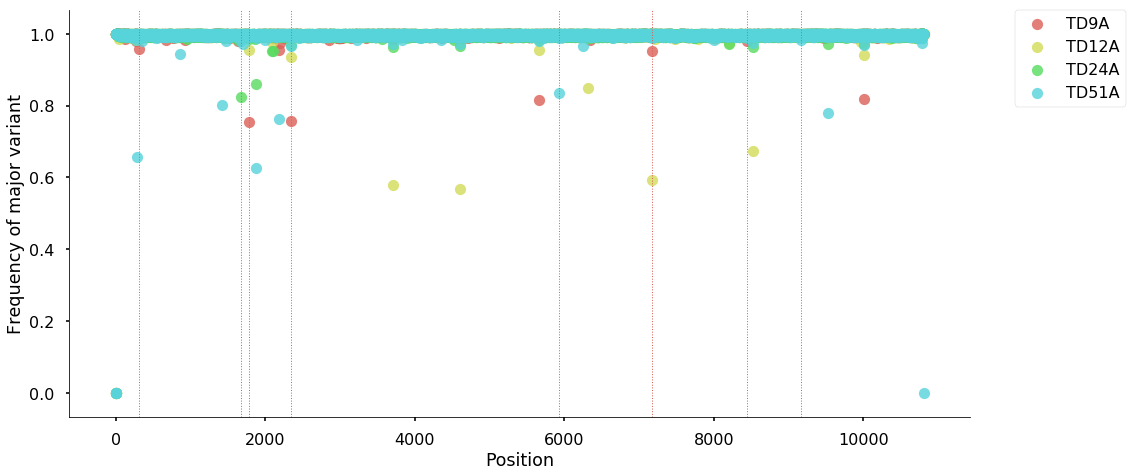

In [62]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
plt.ylabel("Frequency of major variant")
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot_positions()
#plot_genes()

## Diversity through time plot, TLR3 activation

Median values of the diversity per sample:
sample
TD9A     0.004507
TD12A    0.004861
TD24A    0.004768
TD51A    0.004543
Name: 1_major_variant_frequency, dtype: float64
Mean values of the diversity per sample:
sample
TD9A     0.004674
TD12A    0.005343
TD24A    0.004901
TD51A    0.005073
Name: 1_major_variant_frequency, dtype: float64


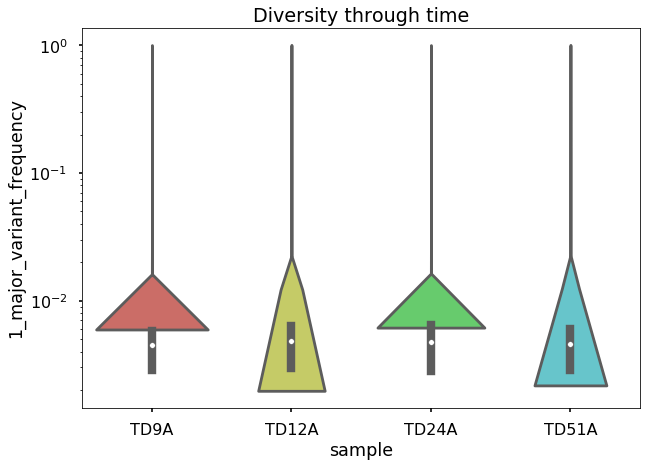

In [63]:
f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
sns.violinplot(x='sample', y="1_major_variant_frequency", data=overlay_table_concat,  ax=ax, bw=0.2)

# giving title to the plot
plt.title("Diversity through time");

medians = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].median()
print("Median values of the diversity per sample:" )
print(medians)
means = overlay_table_concat.groupby(['sample'], sort=False)['1_major_variant_frequency'].mean()
print("Mean values of the diversity per sample:" )
print(means)

The diversity initially increases, but then it may be decreasing between 24 and 51. Not clear with few time points and no replicate.

# Analysis of coverages: overlay and correlations

In [64]:
# construction of the data table
siz = len(DD3_A ['Coverage'])
sample = siz*["DD3A"]+siz*["DD6A"]+siz*["DD9A"]+siz*["DD12A"]+siz*["DD24A"]+siz*["DD51A"]
overlay_table_concat_DDA = pd.DataFrame ({'Position':pd.concat([DD3_A['Position'],DD6_A['Position'],DD9_A['Position'],DD12_A['Position'],DD24_A['Position'],DD51_A['Position']]), 'Coverage':pd.concat([DD3_A ['Coverage'],DD6_A ['Coverage'], DD9_A ['Coverage'],DD12_A ['Coverage'], DD24_A ['Coverage'], DD51_A ['Coverage'] ]), 'sample':sample})

siz = len(DD3_D ['Coverage'])
sample = siz*["DD3D"]+siz*["DD6D"]+siz*["DD9D"]+siz*["DD12D"]+siz*["DD24D"]
overlay_table_concat_DDD = pd.DataFrame ({'Position':pd.concat([DD3_D['Position'],DD6_D['Position'],DD9_D['Position'],DD12_D['Position'],DD24_D['Position']]), 'Coverage':pd.concat([DD3_D ['Coverage'],DD6_D ['Coverage'], DD9_D ['Coverage'],DD12_D ['Coverage'], DD24_D ['Coverage'] ]), 'sample':sample})

siz = len(DD6_E ['Coverage'])
sample = siz*["DD6E"]+siz*["DD9E"]
overlay_table_concat_DDE = pd.DataFrame ({'Position':pd.concat([DD6_E['Position'],DD9_E['Position']]), 'Coverage':pd.concat([DD6_E ['Coverage'],DD9_E ['Coverage']]), 'sample':sample})

siz = len(TD9_A ['Coverage'])
sample = siz*["TD9A"]+siz*["TD12A"]+siz*["TD24A"]+siz*["TD51A"]
overlay_table_concat_TD = pd.DataFrame ({'Position':pd.concat([TD9_A['Position'],TD12_A['Position'],TD24_A['Position'],TD51_A['Position']]), 'Coverage':pd.concat([TD9_A['Coverage'],TD12_A['Coverage'],TD24_A['Coverage'],TD51_A['Coverage'] ]), 'sample':sample})

overlay_table_concat=pd.concat([overlay_table_concat_DDA,overlay_table_concat_DDD, overlay_table_concat_DDE, overlay_table_concat_TD])

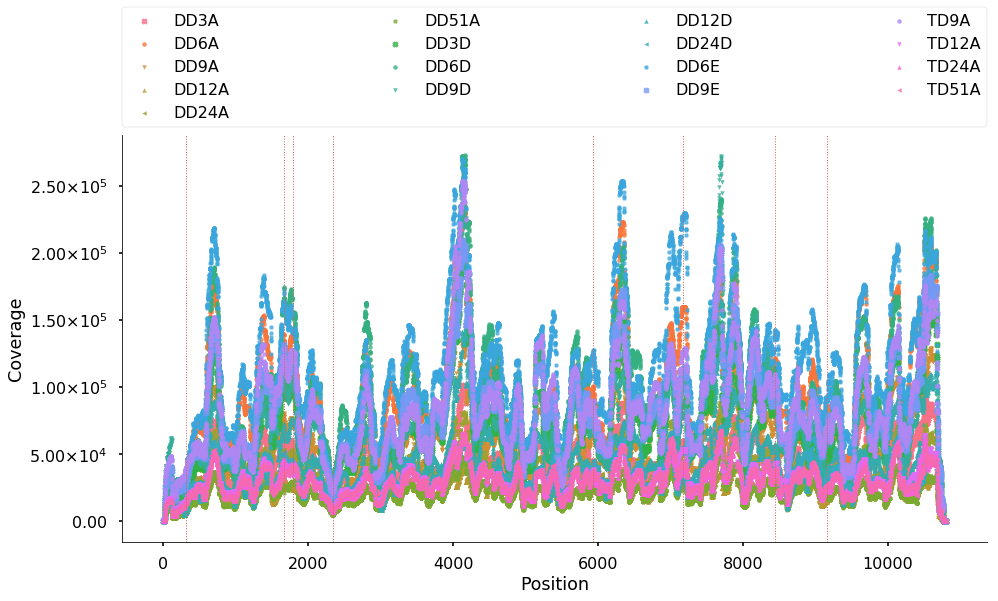

In [65]:
class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


markers = ['x','o','v','^','<', '+', 'x','o','v','^','<', '+', 'x','o','v','^','<']

sns.lmplot( x="Position", y="Coverage", data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True, markers=markers, scatter_kws={"s": 20})

# Format with 2 decimal places
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))

#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0., ncol=4)

plot_positions()
#plot_genes()

In [66]:
siz = len(DD3_A ['Coverage'])
table_for_correlations = pd.DataFrame ({'DD3A':DD3_A ['Coverage'],'DD6_A':DD6_A['Coverage'], 'DD9_A':DD9_A ['Coverage'], 'DD12_A':DD12_A ['Coverage'], 'DD24_A':DD24_A ['Coverage'], 'DD51_A':DD51_A ['Coverage'],
                                        'DD3_D':DD3_D ['Coverage'],'DD6_D':DD6_D ['Coverage'], 'DD9_D':DD9_D ['Coverage'],'DD12_D':DD12_D ['Coverage'], 'DD24_D':DD24_D ['Coverage'],
                                        'DD6_E':DD6_E ['Coverage'], 'DD9_E':DD9_E ['Coverage'],
                                        'TD9_A':TD9_A['Coverage'],'TD12_A':TD12_A['Coverage'],'TD24_A':TD24_A['Coverage'],'TD51_A':TD51_A['Coverage'] })


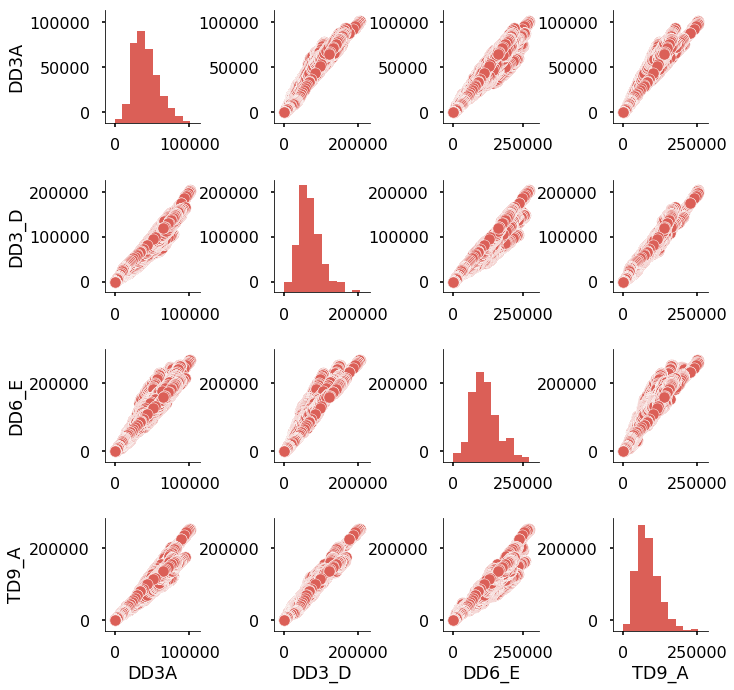

In [67]:
sns.pairplot(table_for_correlations, vars=['DD3A','DD3_D','DD6_E','TD9_A'], kind="scatter")

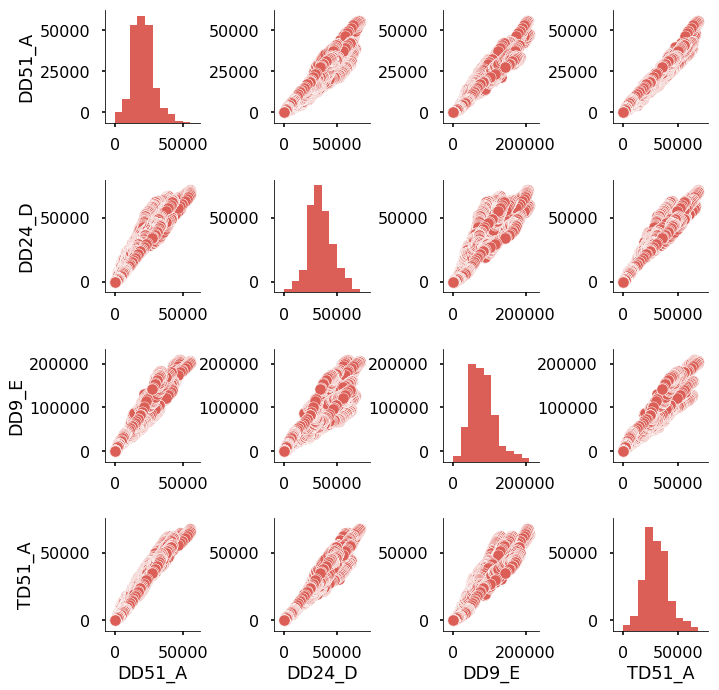

In [68]:
sns.pairplot(table_for_correlations, vars=['DD51_A','DD24_D','DD9_E','TD51_A'], kind="scatter")

Coverage values between samples seem to be quite correlated, although I have not plotted all pairwise correlations.

# Overlays of the major variant frequency per time point, across replicates

## Time point 3

In [69]:
# construction of the data table
siz = len(DD3_A ['Coverage'])
sample = len(DD3_A ['Coverage'])*["DD3A"]+len(DD3_D ['Coverage'])*["DD3D"]
overlay_table_concat_DD3 = pd.DataFrame ({'Position':pd.concat([DD3_A['Position'],DD3_D['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD3_A ['Major_variant_frequency_quality_corrected'],DD3_D ['Major_variant_frequency_quality_corrected']]), 'sample':sample})


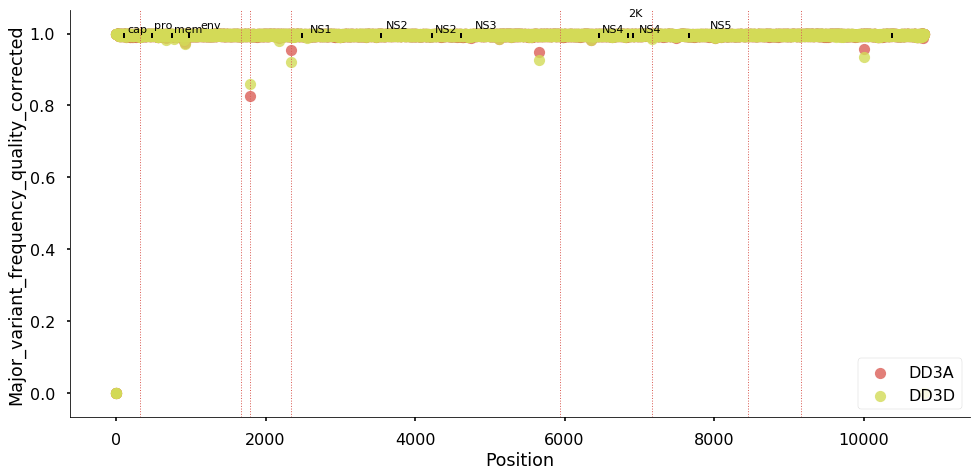

In [70]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat_DD3, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True)
plt.legend(loc='lower right')
plot_positions()
plot_genes()

## Time point 6

In [71]:
# construction of the data table
siz = len(DD6_A ['Coverage'])
sample = len(DD6_A ['Coverage'])*["DD6A"]+len(DD6_D ['Coverage'])*["DD6D"]+len(DD6_E ['Coverage'])*["DD6E"]
overlay_table_concat_DD6 = pd.DataFrame ({'Position':pd.concat([DD6_A['Position'],DD6_D['Position'],DD6_E['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD6_A ['Major_variant_frequency_quality_corrected'],DD6_D ['Major_variant_frequency_quality_corrected'],DD6_E ['Major_variant_frequency_quality_corrected']]), 'sample':sample})


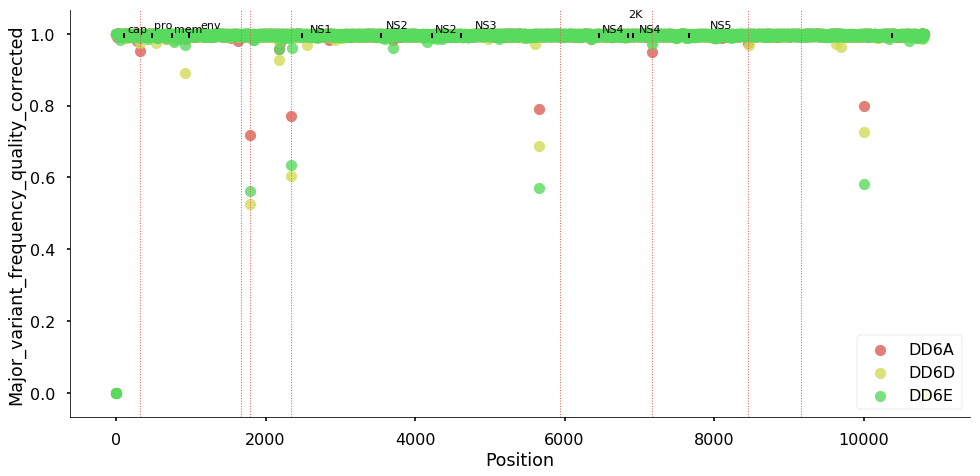

In [72]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat_DD6, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True)
plt.legend(loc='lower right')
plot_positions()
plot_genes()

## Time point 9

In [73]:
# construction of the data table
siz = len(DD9_A ['Coverage'])
sample = len(DD9_A ['Coverage'])*["DD9A"]+len(DD9_D ['Coverage'])*["DD9D"]+len(DD9_E ['Coverage'])*["DD9E"]
overlay_table_concat_DD9 = pd.DataFrame ({'Position':pd.concat([DD9_A['Position'],DD9_D['Position'],DD9_E['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD9_A ['Major_variant_frequency_quality_corrected'],DD9_D ['Major_variant_frequency_quality_corrected'],DD9_E ['Major_variant_frequency_quality_corrected']]), 'sample':sample})


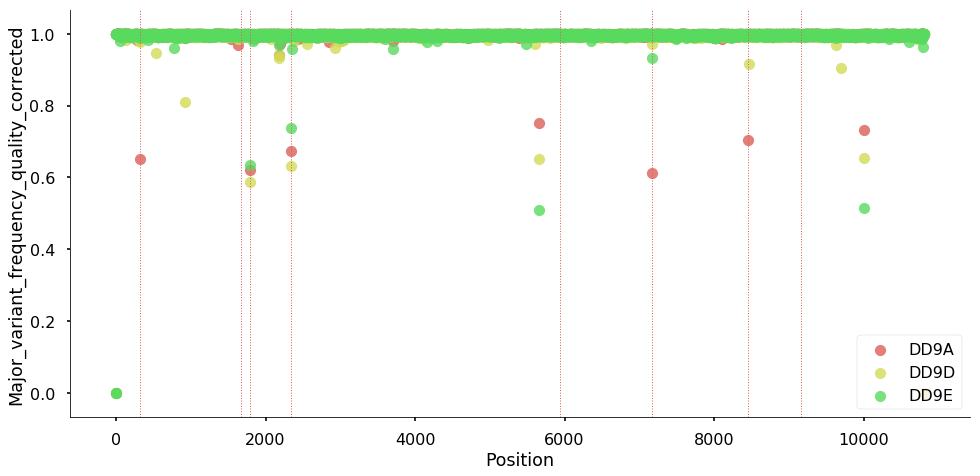

In [74]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat_DD9, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True)
plt.legend(loc='lower right')
plot_positions()
#plot_genes()

## Time point 12

In [75]:
# construction of the data table
siz = len(DD12_A ['Coverage'])
sample = len(DD12_A ['Coverage'])*["DD12A"]+len(DD12_D ['Coverage'])*["DD12D"]
overlay_table_concat_DD12 = pd.DataFrame ({'Position':pd.concat([DD12_A['Position'],DD12_D['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD12_A ['Major_variant_frequency_quality_corrected'],DD12_D ['Major_variant_frequency_quality_corrected']]), 'sample':sample})


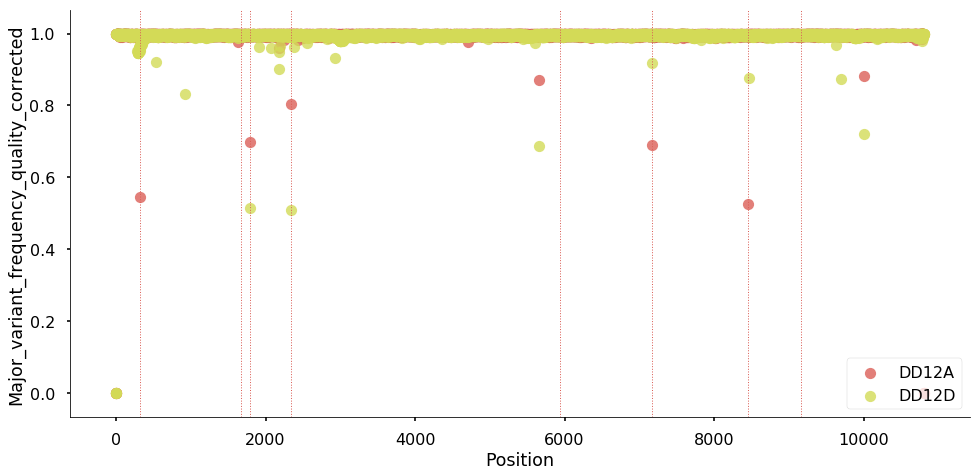

In [76]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat_DD12, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True)
plt.legend(loc='lower right')
plot_positions()
#plot_genes()

## Time point 24

In [77]:
# construction of the data table
siz = len(DD24_A ['Coverage'])
sample = len(DD24_A ['Coverage'])*["DD24A"]+len(DD24_D ['Coverage'])*["DD24D"]
overlay_table_concat_DD24 = pd.DataFrame ({'Position':pd.concat([DD24_A['Position'],DD24_D['Position']]), 'Major_variant_frequency_quality_corrected':pd.concat([DD24_A ['Major_variant_frequency_quality_corrected'],DD24_D ['Major_variant_frequency_quality_corrected']]), 'sample':sample})


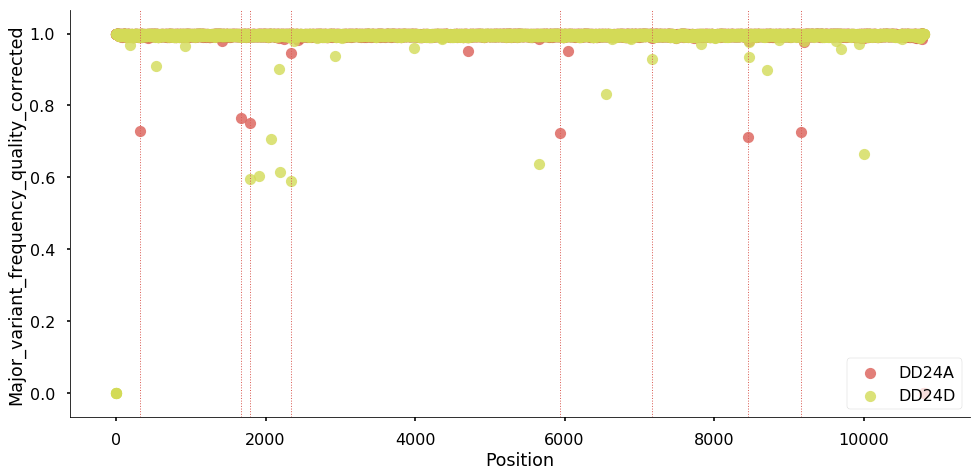

In [78]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=overlay_table_concat_DD24, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True)
plt.legend(loc='lower right')
plot_positions()
#plot_genes()

# Synonymous and non-synonymous mutations

### Experiment A, day 3

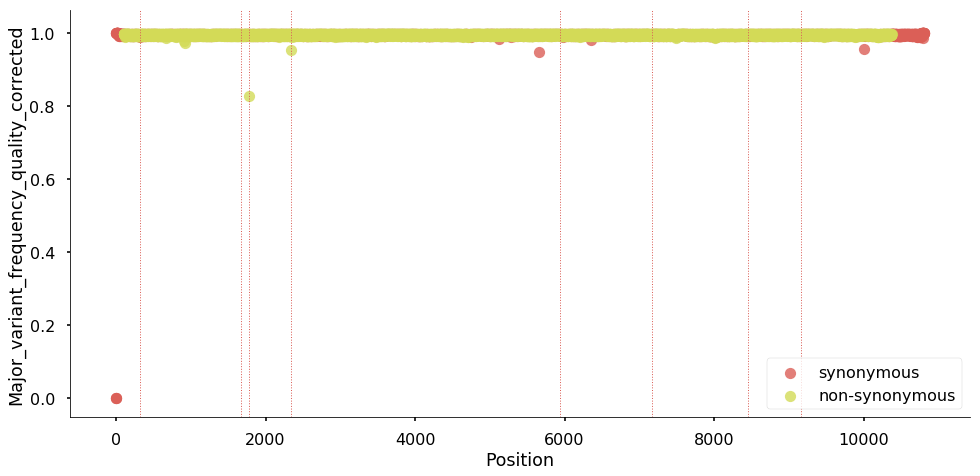

In [79]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=DD3_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


### Experiment A, day 6

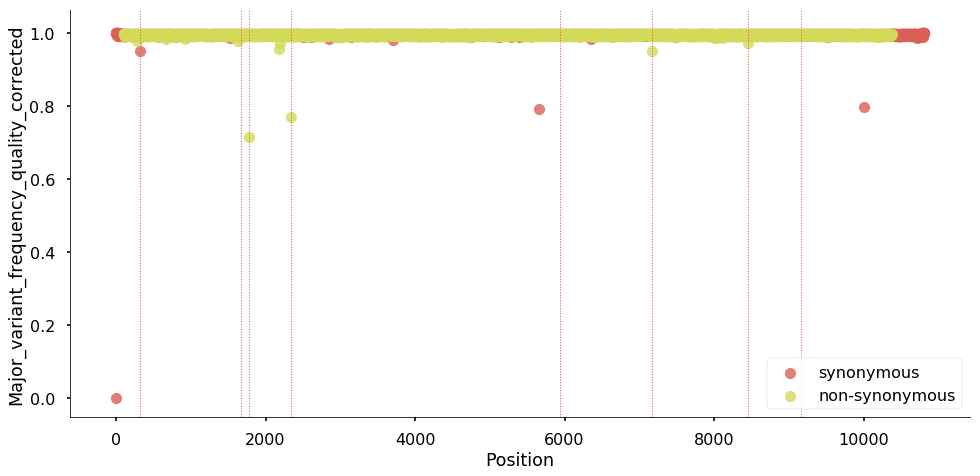

In [80]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=DD6_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()

### Experiment A, day 9

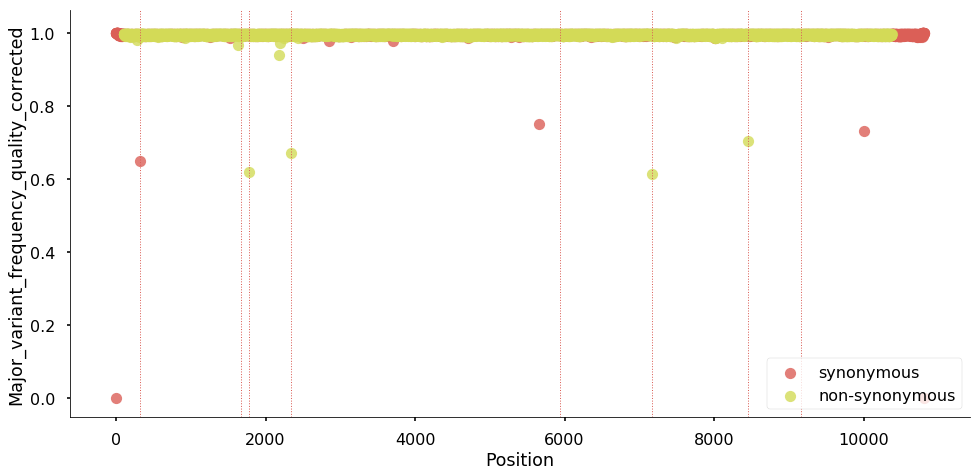

In [81]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=DD9_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()

### Experiment A, day 12

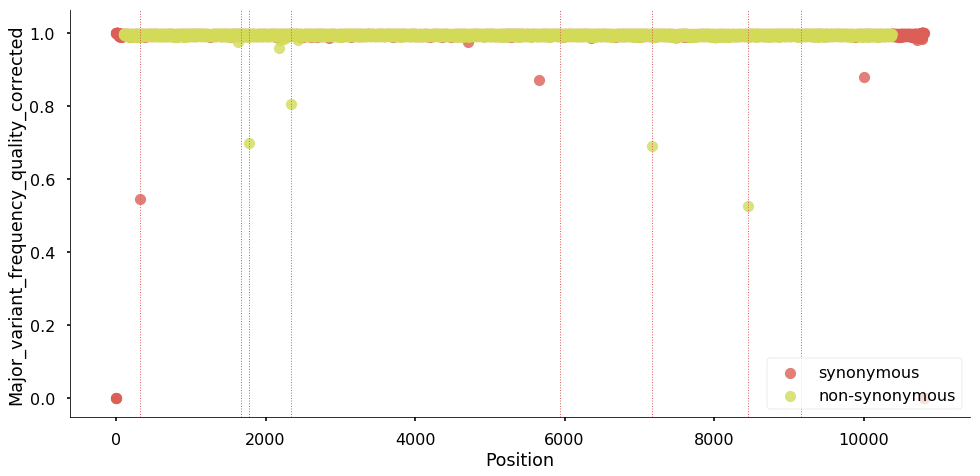

In [82]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=DD12_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()

### Experiment A, day 24

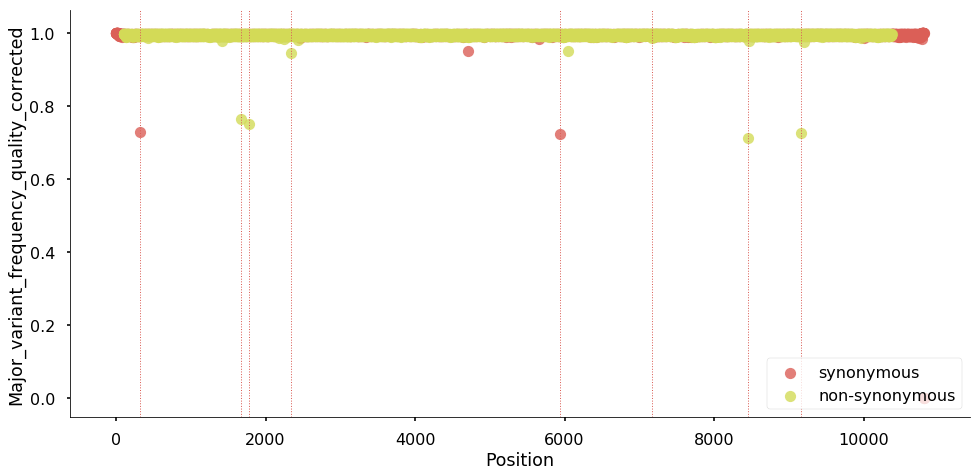

In [83]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=DD24_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


### Experiment A, day 51

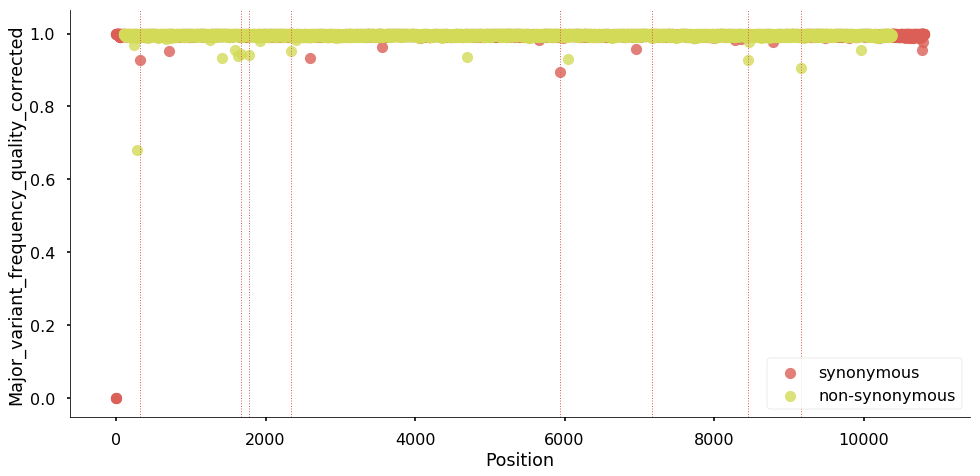

In [84]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=DD51_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


### Experiment D, day 24

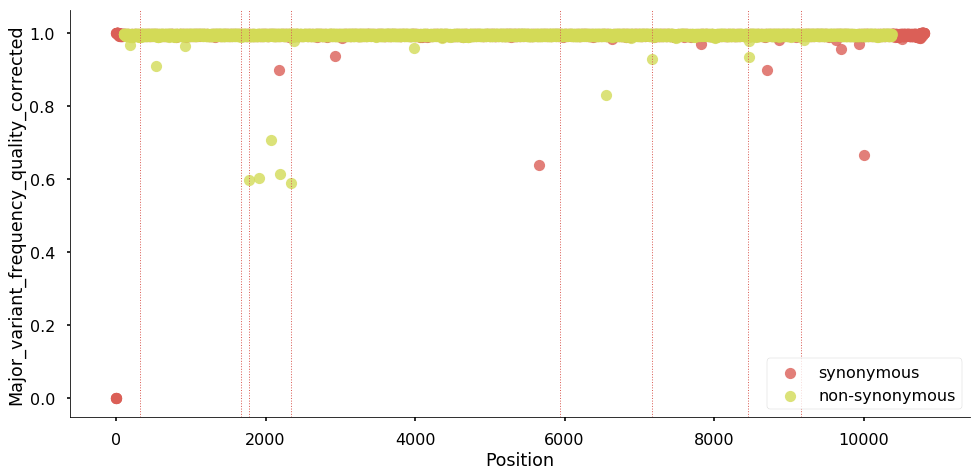

In [85]:
sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=DD24_D, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


## Frequency of the second variant

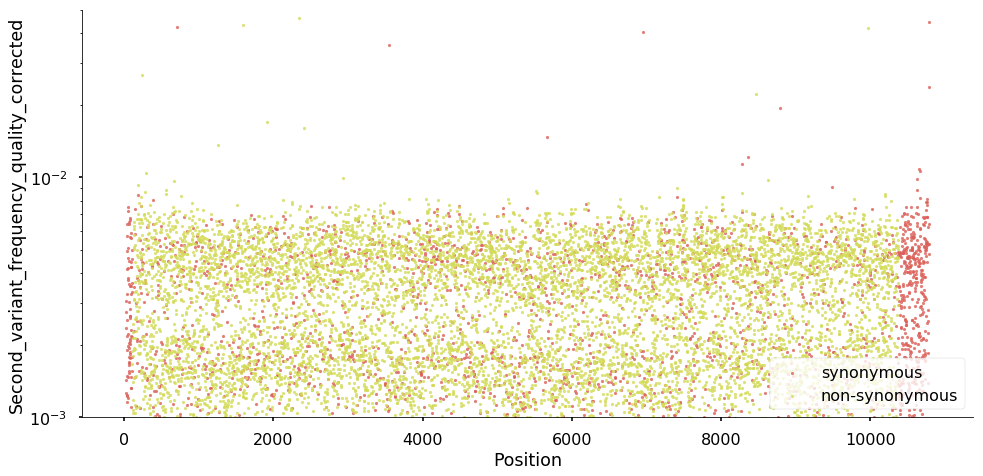

In [86]:
lm=sns.lmplot( x="Position", y="Second_variant_frequency_quality_corrected", data=DD51_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2, scatter_kws={"s": 10})
axes = lm.axes
axes[0,0].set_ylim(0.001,0.05)
axes[0,0].set(yscale="log")

plt.legend(loc='lower right')

#sns.lmplot( x="position", y="majorbase_ratio", data=DD51_A, fit_reg=False, hue='synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
#plt.legend(loc='lower right')


is_synonymous
non-synonymous    0.003032
synonymous        0.002671
Name: Second_variant_frequency_quality_corrected, dtype: float64
T-test p-value: 0.277844501149


Text(0.5,1,'Frequency of the second variant, synonymous vs non-synonymous, day 51')

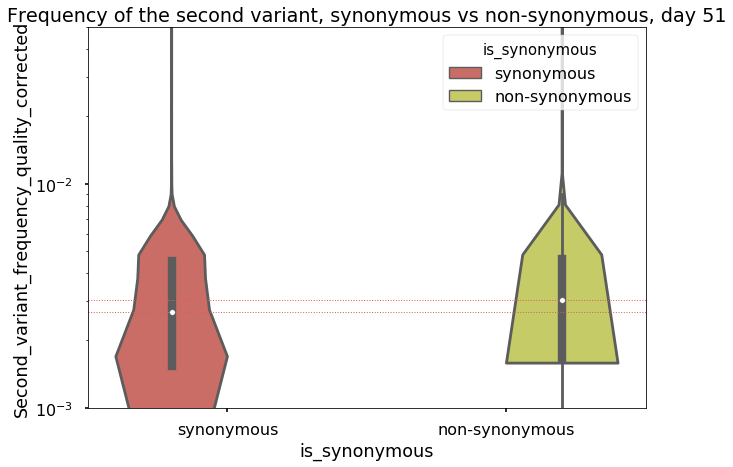

In [87]:
print( DD51_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median())
syn = DD51_A['Second_variant_frequency_quality_corrected'][DD51_A['is_synonymous']=="synonymous"]
nonsyn = DD51_A['Second_variant_frequency_quality_corrected'][DD51_A['is_synonymous']=="non-synonymous"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))

f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=DD51_A,  hue='is_synonymous', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = DD51_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
# giving title to the plot
plt.title("Frequency of the second variant, synonymous vs non-synonymous, day 51")


The difference in frequencies of the variants do not differ significantly between synonymous and non-synonymous variants at time point 51.

is_synonymous
non-synonymous    0.002968
synonymous        0.002605
Name: Second_variant_frequency_quality_corrected, dtype: float64
T-test p-value: 0.931816808252


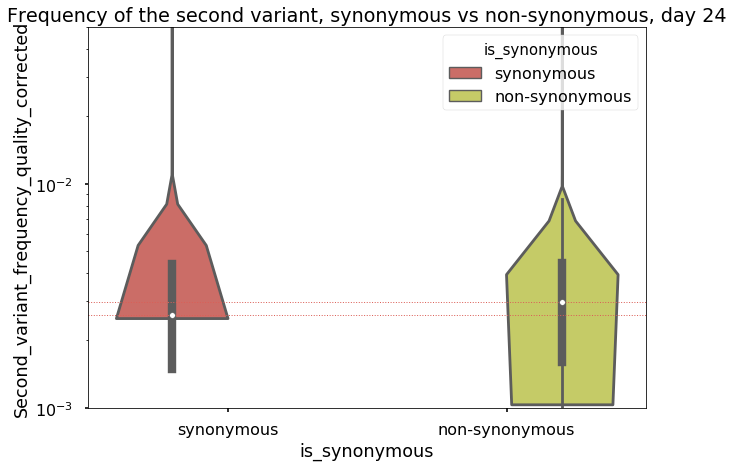

In [88]:
print( DD24_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median())
syn = DD24_A['Second_variant_frequency_quality_corrected'][DD24_A['is_synonymous']=="synonymous"]
nonsyn = DD24_A['Second_variant_frequency_quality_corrected'][DD24_A['is_synonymous']=="non-synonymous"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))


f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=DD24_A,  hue='is_synonymous', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = DD24_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
# giving title to the plot
plt.title("Frequency of the second variant, synonymous vs non-synonymous, day 24");


The difference in frequencies of the variants do not differ significantly between synonymous and non-synonymous variants at time point 24.

is_synonymous
non-synonymous    0.003120
synonymous        0.002664
Name: Second_variant_frequency_quality_corrected, dtype: float64
T-test p-value: 0.84857732684


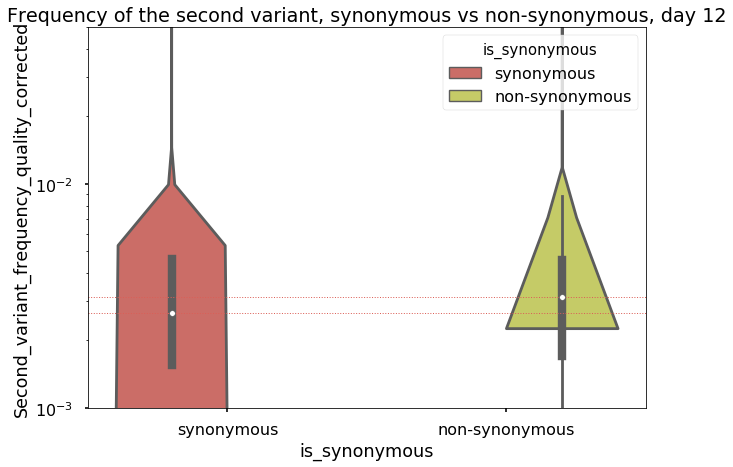

In [89]:
print( DD12_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median())
syn = DD12_A['Second_variant_frequency_quality_corrected'][DD12_A['is_synonymous']=="synonymous"]
nonsyn = DD12_A['Second_variant_frequency_quality_corrected'][DD12_A['is_synonymous']=="non-synonymous"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))

f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=DD12_A,  hue='is_synonymous', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = DD12_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
# giving title to the plot
plt.title("Frequency of the second variant, synonymous vs non-synonymous, day 12");


The difference in frequencies of the variants do not differ significantly between synonymous and non-synonymous variants at time point 12.

is_synonymous
non-synonymous    0.002987
synonymous        0.002717
Name: Second_variant_frequency_quality_corrected, dtype: float64
T-test p-value: 0.513497856777


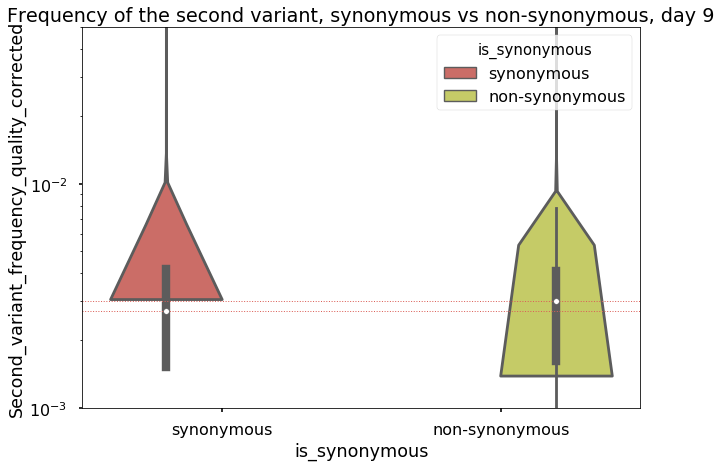

In [90]:
print( DD9_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median())
syn = DD9_A['Second_variant_frequency_quality_corrected'][DD9_A['is_synonymous']=="synonymous"]
nonsyn = DD9_A['Second_variant_frequency_quality_corrected'][DD9_A['is_synonymous']=="non-synonymous"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))

f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=DD9_A,  hue='is_synonymous', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = DD9_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
# giving title to the plot
plt.title("Frequency of the second variant, synonymous vs non-synonymous, day 9");


The difference in frequencies of the variants do not differ significantly between synonymous and non-synonymous variants at time point 9.

is_synonymous
non-synonymous    0.003118
synonymous        0.002731
Name: Second_variant_frequency_quality_corrected, dtype: float64
T-test p-value: 0.575956766906


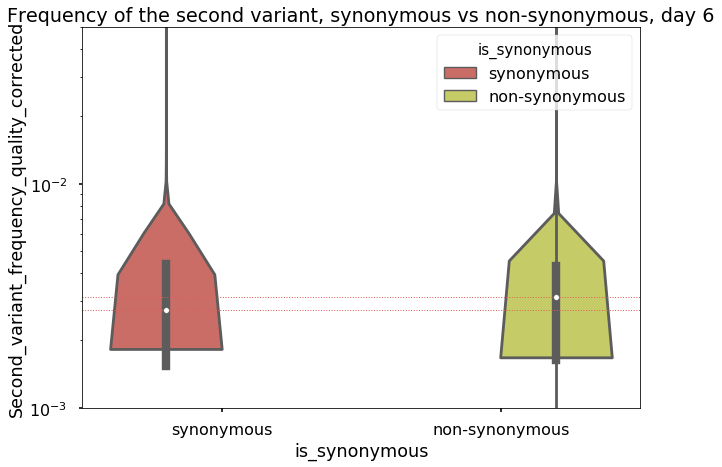

In [91]:
print( DD6_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median())
syn = DD6_A['Second_variant_frequency_quality_corrected'][DD6_A['is_synonymous']=="synonymous"]
nonsyn = DD6_A['Second_variant_frequency_quality_corrected'][DD6_A['is_synonymous']=="non-synonymous"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))

f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=DD6_A,  hue='is_synonymous', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = DD6_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
# giving title to the plot
plt.title("Frequency of the second variant, synonymous vs non-synonymous, day 6");


The difference in frequencies of the variants do not differ significantly between synonymous and non-synonymous variants at time point 6.

is_synonymous
non-synonymous    0.003042
synonymous        0.002719
Name: Second_variant_frequency_quality_corrected, dtype: float64
T-test p-value: 0.091147469384


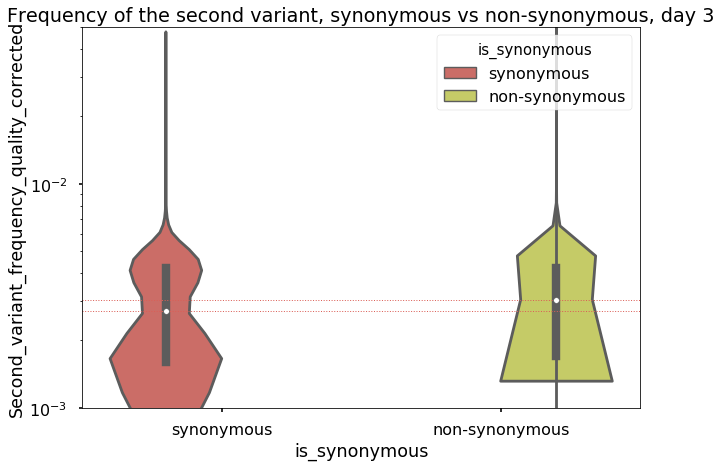

In [92]:
print( DD3_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median())
syn = DD3_A['Second_variant_frequency_quality_corrected'][DD3_A['is_synonymous']=="synonymous"]
nonsyn = DD3_A['Second_variant_frequency_quality_corrected'][DD3_A['is_synonymous']=="non-synonymous"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))

f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=DD3_A,  hue='is_synonymous', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = DD3_A.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
# giving title to the plot
plt.title("Frequency of the second variant, synonymous vs non-synonymous, day 3");


The difference in frequencies of the variants do not differ significantly between synonymous and non-synonymous variants at time point 3.

### Control, replicate D, time point 24

is_synonymous
non-synonymous    0.003246
synonymous        0.002929
Name: Second_variant_frequency_quality_corrected, dtype: float64
T-test p-value: 0.729639921175


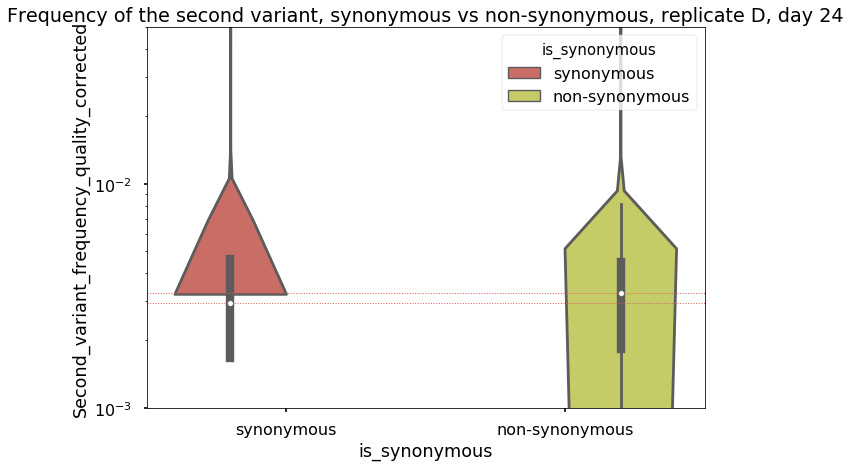

In [93]:
print( DD24_D.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median())
syn = DD24_D['Second_variant_frequency_quality_corrected'][DD24_D['is_synonymous']=="synonymous"]
nonsyn = DD24_D['Second_variant_frequency_quality_corrected'][DD24_D['is_synonymous']=="non-synonymous"]
print("T-test p-value: "+str(ttest_ind(syn, nonsyn)[1]))


f, ax = plt.subplots(figsize=(10, 7))
ax.set(yscale="log")
lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=DD24_D,  hue='is_synonymous', ax=ax, bw=0.2)
axes = lm.axes
axes.set_ylim(0.001,0.05)
axes.set(yscale="log")

medians = DD24_D.groupby(['is_synonymous'])['Second_variant_frequency_quality_corrected'].median().values
plt.axhline(y=medians[0], linewidth=1, linestyle=':')
plt.axhline(y=medians[1], linewidth=1, linestyle=':')
# giving title to the plot
plt.title("Frequency of the second variant, synonymous vs non-synonymous, replicate D, day 24");


### TLR3 activation, day 9

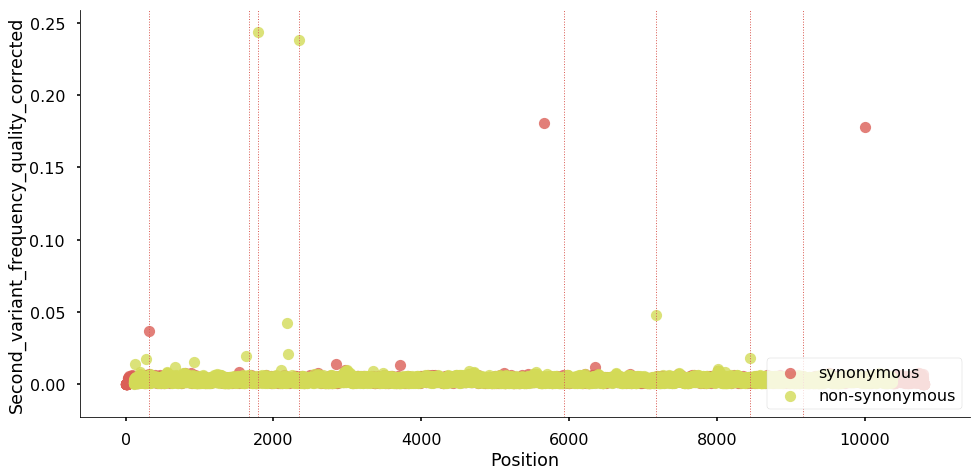

In [94]:
sns.lmplot( x="Position", y="Second_variant_frequency_quality_corrected", data=TD9_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


### TLR3 activation, day 12

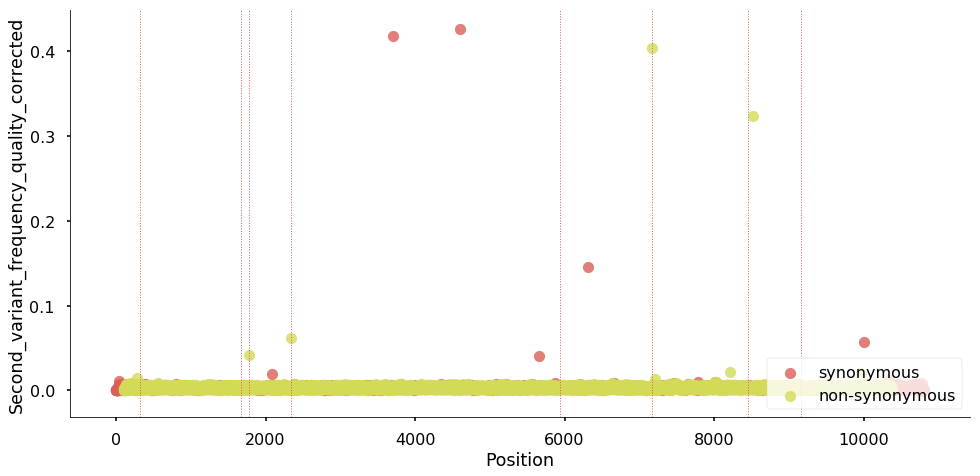

In [95]:
sns.lmplot( x="Position", y="Second_variant_frequency_quality_corrected", data=TD12_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


### TLR3 activation, day 24

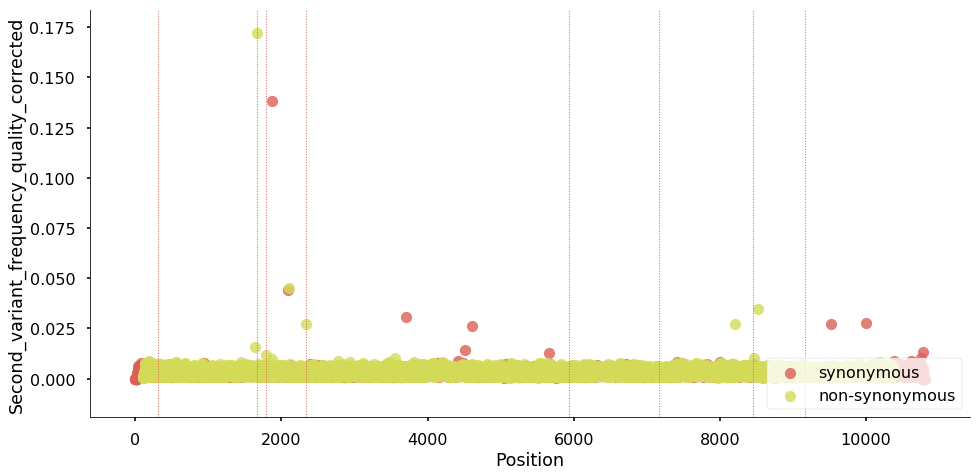

In [96]:
sns.lmplot( x="Position", y="Second_variant_frequency_quality_corrected", data=TD24_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


### TLR3 activation, day 51

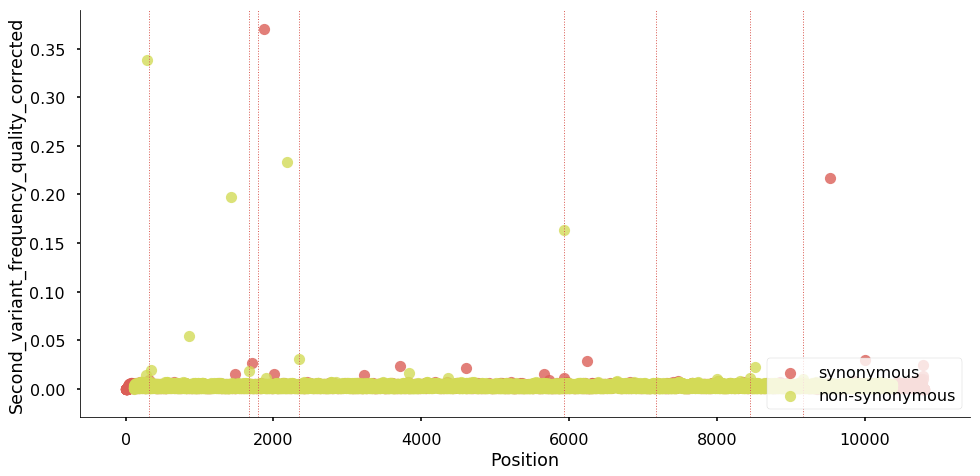

In [97]:
sns.lmplot( x="Position", y="Second_variant_frequency_quality_corrected", data=TD51_A, fit_reg=False, hue='is_synonymous', legend=False, size=7, aspect=2) #, markers=DD3_A['synonymous'])
plt.legend(loc='lower right')
plot_positions()
#plot_genes()
# giving title to the plot
#plt.title("Synonymous and non-synonymous polymorphisms, experiment A day 3");


# Frequencies of the second variant, synonymous vs non-synonymous, only in positions above a diversity threshold

In the density plots above (figures 47, 49, 51), we saw that variants with a log-diversity above -5.5 rose in frequency through time. Those variants presumably are under selection. We therefore expect to see a difference between synonymous (putatively nearly-neutral) and non-synonymous variants (putatively under selection).

### Useful functions

In [98]:
# We select variants with log-diversity above -5.5

threshold=np.exp(-5.5)

def above_55 (row, threshold):
    if row['1_major_variant_frequency']>=threshold :
        return "right"  
    else:
        return "left"
    
def print_means_and_medians(table):
    print("\n\t\tMedians:")
    nums = table.groupby(['is_synonymous', 'peak'])['Second_variant_frequency_quality_corrected'].median().values
    print("\tLeft peak:")
    print("Non-synonymous: "+str(nums [0])+"; Synonymous: "+str(nums [2]))
    print("\tRight peak:")
    print("Non-synonymous: "+str(nums [1])+"; Synonymous: "+str(nums [3]))
    print("\n\t\tMeans:")
    nums = table.groupby(['is_synonymous', 'peak'])['Second_variant_frequency_quality_corrected'].mean().values
    print("\tLeft peak:")
    print("Non-synonymous: "+str(nums [0])+"; Synonymous: "+str(nums [2]))
    print("\tRight peak:")
    print("Non-synonymous: "+str(nums [1])+"; Synonymous: "+str(nums [3]))
    print("\n\t\tNumber of positions:")
    nums = table.groupby(['is_synonymous', 'peak'])['Second_variant_frequency_quality_corrected'].size().values
    print("\tLeft peak:")
    print("Non-synonymous: "+str(nums [0])+"; Synonymous: "+str(nums [2]))
    print("\tRight peak:")
    print("Non-synonymous: "+str(nums [1])+"; Synonymous: "+str(nums [3]))
    print("\n\t\tFraction of variants that are non-synonymous:")
    nums = table.groupby(['is_synonymous', 'peak'])['Second_variant_frequency_quality_corrected'].size()
    print ("\tLeft peak: ")
    print(nums[0]/(nums[0]+nums[2]))
    print ("\tRight peak: ")
    print(nums[1]/(nums[1]+nums[3]))
    
def test_distributions(table):
    syn_left = table['Second_variant_frequency_quality_corrected'][(table['is_synonymous']=="synonymous") & (table['peak']=="left")]
    non_syn_left = table['Second_variant_frequency_quality_corrected'][(table['is_synonymous']=="non-synonymous") & (table['peak']=="left")]
    syn_right = table['Second_variant_frequency_quality_corrected'][(table['is_synonymous']=="synonymous") & (table['peak']=="right")]
    non_syn_right = table['Second_variant_frequency_quality_corrected'][(table['is_synonymous']=="non-synonymous") & (table['peak']=="right")]
    print("T-test p-value: synonymous vs non-synonymous mutations, left peak: "+str(ttest_ind(syn_left, non_syn_left)[1]))
    print("T-test p-value: synonymous vs non-synonymous mutations, right peak: "+str(ttest_ind(syn_right, non_syn_right)[1]))
    print("Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, left peak: "+str(mannwhitneyu(syn_left, non_syn_left)[1]))
    print("Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, right peak: "+str(mannwhitneyu(syn_right, non_syn_right)[1]))
    
def violin_plots_syn_peaks (table):
    f, ax = plt.subplots(figsize=(10, 7))
    ax.set(yscale="log")
    lm=sns.violinplot(x='is_synonymous', y="Second_variant_frequency_quality_corrected", data=table,  hue='peak', ax=ax, bw=0.2)
    axes = lm.axes
    axes.set_ylim(0.0005,0.5)
    axes.set_ylabel("Frequency of the second variant")
    axes.set(yscale="log")

    medians = table.groupby(['is_synonymous', 'peak'])['Second_variant_frequency_quality_corrected'].median().values
    plt.axhline(y=medians[0], linewidth=1, linestyle=':')
    plt.axhline(y=medians[1], linewidth=1, linestyle=':')
    plt.axhline(y=medians[2], linewidth=1, linestyle=':')
    plt.axhline(y=medians[3], linewidth=1, linestyle=':')
    # giving title to the plot
    plt.title("Frequency of the second variant, synonymous vs non-synonymous");


### Sample DD51A


		Medians:
	Left peak:
Non-synonymous: 0.001553; Synonymous: 0.001478
	Right peak:
Non-synonymous: 0.004414; Synonymous: 0.004432

		Means:
	Left peak:
Non-synonymous: 0.0015889578555; Synonymous: 0.00147397169811
	Right peak:
Non-synonymous: 0.00466427887442; Synonymous: 0.00475689719626

		Number of positions:
	Left peak:
Non-synonymous: 3488; Synonymous: 1166
	Right peak:
Non-synonymous: 4762; Synonymous: 1391

		Fraction of variants that are non-synonymous:
	Left peak: 
0.749462827675
	Right peak: 
0.77393141557
T-test p-value: synonymous vs non-synonymous mutations, left peak: 1.24195515984e-12
T-test p-value: synonymous vs non-synonymous mutations, right peak: 0.560356573421
Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, left peak: 1.06123983234e-07
Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, right peak: 0.433559211835


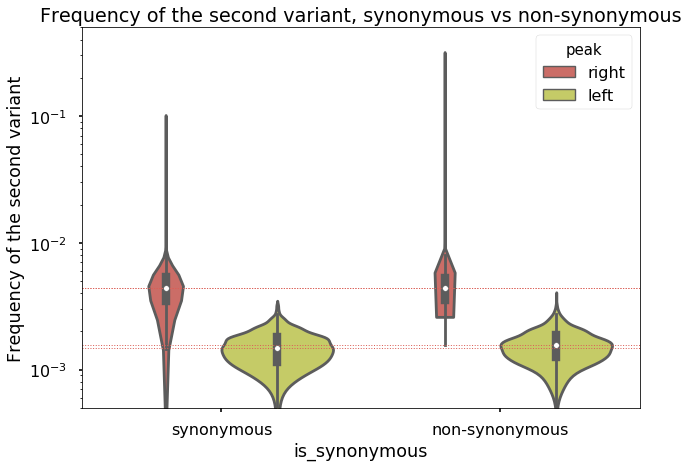

In [99]:
DD51_A['peak'] = DD51_A.apply (lambda row: above_55 (row, threshold),axis=1)

print_means_and_medians(DD51_A)
test_distributions(DD51_A)

violin_plots_syn_peaks(DD51_A)

### Sample DD24D


		Medians:
	Left peak:
Non-synonymous: 0.001733; Synonymous: 0.001635
	Right peak:
Non-synonymous: 0.004341; Synonymous: 0.004543

		Means:
	Left peak:
Non-synonymous: 0.00176403779395; Synonymous: 0.00162575971731
	Right peak:
Non-synonymous: 0.00483885985006; Synonymous: 0.00532640199846

		Number of positions:
	Left peak:
Non-synonymous: 3572; Synonymous: 1132
	Right peak:
Non-synonymous: 4802; Synonymous: 1301

		Fraction of variants that are non-synonymous:
	Left peak: 
0.759353741497
	Right peak: 
0.786826151073
T-test p-value: synonymous vs non-synonymous mutations, left peak: 1.07211545076e-17
T-test p-value: synonymous vs non-synonymous mutations, right peak: 0.221100266126
Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, left peak: 2.77199501366e-10
Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, right peak: 4.23497980933e-10


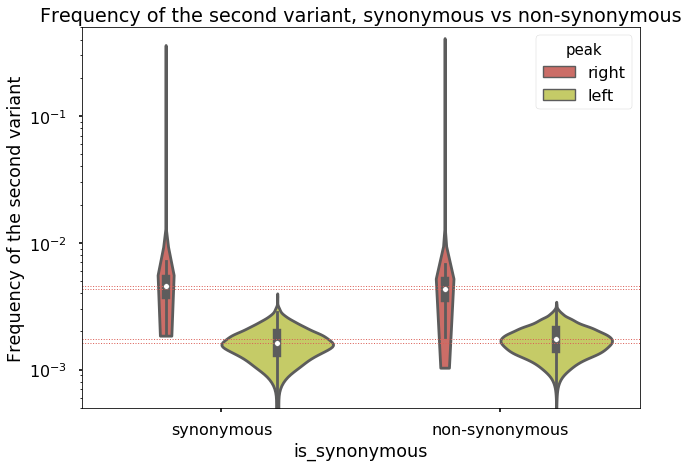

In [100]:
DD24_D['peak'] = DD24_D.apply (lambda row: above_55 (row, threshold),axis=1)

print_means_and_medians(DD24_D)
test_distributions(DD24_D)

violin_plots_syn_peaks(DD24_D)

### Sample TD51A


		Medians:
	Left peak:
Non-synonymous: 0.001628; Synonymous: 0.001546
	Right peak:
Non-synonymous: 0.004223; Synonymous: 0.0044

		Means:
	Left peak:
Non-synonymous: 0.00167460760171; Synonymous: 0.00155830716135
	Right peak:
Non-synonymous: 0.00449187551329; Synonymous: 0.00499281322957

		Number of positions:
	Left peak:
Non-synonymous: 3736; Synonymous: 1159
	Right peak:
Non-synonymous: 4627; Synonymous: 1285

		Fraction of variants that are non-synonymous:
	Left peak: 
0.763227783453
	Right peak: 
0.782645466847
T-test p-value: synonymous vs non-synonymous mutations, left peak: 8.55575114427e-13
T-test p-value: synonymous vs non-synonymous mutations, right peak: 0.0590750212441
Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, left peak: 1.76269000071e-08
Mann-Whitney U-test p-value: synonymous vs non-synonymous mutations, right peak: 8.2333962359e-06


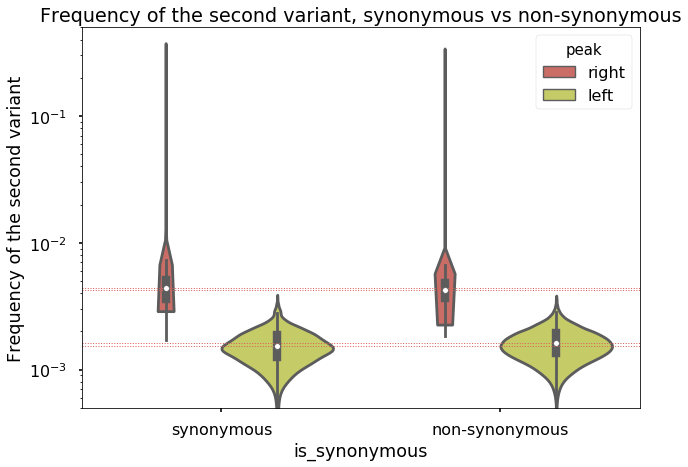

In [101]:
TD51_A['peak'] = TD51_A.apply (lambda row: above_55 (row, threshold),axis=1)

print_means_and_medians(TD51_A)
test_distributions(TD51_A)

violin_plots_syn_peaks(TD51_A)

In all three analyses above, we see that for both peaks there are more non-synonymous variants than synonymous variants. This is expected because there are much more ways to make a non-synonymous substitution than to make a synonymous substitution (e.g. mutations in the first 2 positions of the codons nearly always result in a non-synonymous substitution). 

However, the ratio of the number of non-synonymous variants over all variants is smaller in the left peak (hypothetically variants created during the 2-day amplification step), than in the right peak (hypothetically variants created during experimental evolution). These excess non-synonymous variants in the right peak could be beneficial, and therefore have increased thanks to selection, or could be neutral or slightly deleterious, in which case they would have increased by genetic draft, i.e. because they are linked on an haplotype to positively selected variants.

Looking at the frequencies of the variants, we see that the non-synonymous variants are significantly more frequent than the synonymous variants in the left peak, while it is not the case in the right peak. The results for the first peak may be linked to mutation rate biases, e.g. a mutation towards A would increase the frequency of A variants. This has not been investigated. The fact that the non-synonymous variants are on average less frequent than the synonymous variants in the right peak hints that most non-synonymous variants may be slightly deleterious. However, there seems to be an excess of high-frequency non-synonymous variants compared to the synonymous variants, so those may have been positively selected.


# Mutational patterns, per peak.

### Useful functions

In [112]:
mut_dict = dict()
mut_dict["AC"] = 0
mut_dict["AG"] = 0
mut_dict["AT"] = 0
mut_dict["CA"] = 0
mut_dict["CG"] = 0
mut_dict["CT"] = 0
mut_dict["GA"] = 0
mut_dict["GC"] = 0
mut_dict["GT"] = 0
mut_dict["TA"] = 0
mut_dict["TC"] = 0
mut_dict["TG"] = 0
mut_dict["NN"] = 0
mut_dict["NA"] = 0
mut_dict["NC"] = 0
mut_dict["NG"] = 0
mut_dict["NT"] = 0
mut_dict["AN"] = 0
mut_dict["CN"] = 0
mut_dict["GN"] = 0
mut_dict["TN"] = 0


def extract_mutations_row (row, mut_dict):
    mut_dict[row['Major_variant']+row['Second_variant'] ] +=1

def extractMutations(table, mut_dict):
    other_dict = mut_dict.copy()
    table.apply (lambda row: extract_mutations_row (row, other_dict),axis=1)
    return other_dict

def normalize_dict(mut_dict):
    other_dict = mut_dict.copy()
    sum_A = other_dict["AC"] + other_dict["AG"] + other_dict["AT"] + other_dict["AN"] 
    sum_C = other_dict["CA"] + other_dict["CG"] + other_dict["CT"] + other_dict["CN"] 
    sum_G = other_dict["GA"] + other_dict["GC"] + other_dict["GT"] + other_dict["GN"] 
    sum_T = other_dict["TA"] + other_dict["TC"] + other_dict["TG"] + other_dict["TN"] 
    other_dict["AC"] = other_dict["AC"] /sum_A
    other_dict["AG"] = other_dict["AG"] /sum_A
    other_dict["AT"] = other_dict["AT"] /sum_A
    other_dict["CA"] = other_dict["CA"] /sum_C
    other_dict["CG"] = other_dict["CG"] /sum_C
    other_dict["CT"] = other_dict["CT"] /sum_C
    other_dict["GA"] = other_dict["GA"] /sum_G
    other_dict["GC"] = other_dict["GC"] /sum_G
    other_dict["GT"] = other_dict["GT"] /sum_G
    other_dict["TA"] = other_dict["TA"] /sum_T
    other_dict["TC"] = other_dict["TC"] /sum_T
    other_dict["TG"] = other_dict["TG"] /sum_T
    return other_dict

def print_mutation_patterns(mut_dict):
    print("\t\tRaw counts: ")
    for k,v in mut_dict.items():
        if ("N" not in k):
            print(k+" : " + str(v))
    print ("\t\tFrequencies: ")
    norm_dict = normalize_dict (mut_dict)
    for k,v in norm_dict.items():
        if ("N" not in k):
            print(k+" : " + str(v))

def plot_mutation_patterns (left_dict, right_dict):
    left_dict = normalize_dict (left_dict)
    right_dict = normalize_dict (right_dict)
    names = []
    left_values = []
    right_values = []
    peaks_1=[]
    peaks_2=[]
    for k,v in left_dict.items():
        if ("N" not in k):
            names.append(k)
            left_values.append(v)
            right_values.append(right_dict[k])
            peaks_1.append("left")
            peaks_2.append("right")
    tot_names= names + names
    tot_values = left_values + right_values
    tot_peaks = peaks_1 + peaks_2
    df = pd.DataFrame({"peak" : tot_peaks, "mutation" : tot_names,
                   "frequency" : tot_values})
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(len(names))
    bar_width = 0.35
    opacity = 0.8
 
    rects1 = plt.bar(index, left_values, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Left')
 
    rects2 = plt.bar(index + bar_width, right_values, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Right')
 
    plt.xlabel('Mutation')
    plt.ylabel('Frequency')
    plt.title('Mutation frequency')
    plt.xticks(index + bar_width, names)
    plt.legend()
 
    plt.tight_layout()
    plt.show()

def compute_and_plot_mutation_patterns(table, mut_dict):
    left_dict = extractMutations(table[table['peak']=="left"], mut_dict)
    right_dict = extractMutations(table[table['peak']=="right"], mut_dict)
    plot_mutation_patterns(left_dict, right_dict)

### Sample DD51A

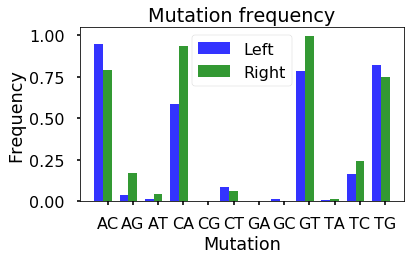

In [113]:
compute_and_plot_mutation_patterns(DD51_A, mut_dict)


## Sample DD24_D

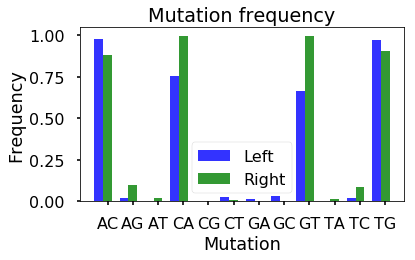

In [114]:
compute_and_plot_mutation_patterns(DD24_D, mut_dict)


## Sample TD_51

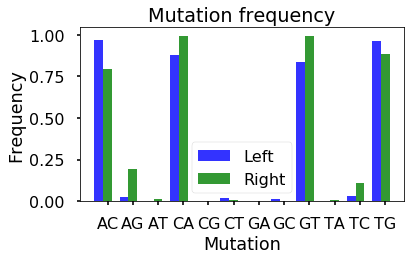

In [115]:
compute_and_plot_mutation_patterns(TD51_A, mut_dict)


### Conclusion on mutation patterns
There are consistent differences between the mutation patterns of the left and right peaks. For instance, the frequency of the AC and TG mutations are always larger in the left peak, and those of CA and GT always lower in the left peak.
The hypothesis we have for explaining the left peak mutations is that they come from errors during PCR amplification. A quick look at a paper on PCR errors (https://www-ncbi-nlm-nih-gov/pmc/articles/PMC5457411/) does not seem to recover this mutation pattern however, so I am a bit puzzled.

## Intersections between the positions that rise in frequency between experiments 

### AD

In [100]:
a = increasing_A.keys()
b = increasing_D.keys()
intersection = list(set(a) & set(b))
print ("Positions that increase in both control replicates A and D: ")
print(intersection)
print("... and that are non-synonymous at time 51, replicate A:")
for i in intersection:
    if DD51_A['is_synonymous'][i]=="non-synonymous":
        print (i)

Positions that increase in both control replicates A and D: 
[10153, 138, 2804]
... and that are non-synonymous at time 51, replicate A:
10153
138
2804


### ADE

In [101]:
a = intersection
b = increasing_E.keys()
intersection = list(set(a) & set(b))
print ("Positions that increase in control replicates A, D and E: ")
print(intersection)
print("... and that are non-synonymous at time 51, replicate A:")
for i in intersection:
    if DD51_A['is_synonymous'][i]=="non-synonymous":
        print (i)

Positions that increase in control replicates A, D and E: 
[2804]
... and that are non-synonymous at time 51, replicate A:
2804


### ADETLR3

In [102]:
a = intersection
b = increasing_TA.keys()
intersection = list(set(a) & set(b))
print ("Positions that increase in control replicates A, D, E and TLR3: ")
print(intersection)

Positions that increase in control replicates A, D, E and TLR3: 
[]


### A and TLR3

In [103]:
a = increasing_A.keys()
b = increasing_TA.keys()
intersection = list(set(a) & set(b))
print ("Positions that increase in control replicate A,and TLR3: ")
print(intersection)
print("... and that are non-synonymous at time 51, replicate A:")
for i in intersection:
    if DD51_A['is_synonymous'][i]=="non-synonymous":
        print (i)

Positions that increase in control replicate A,and TLR3: 
[10360, 1785, 4900]
... and that are non-synonymous at time 51, replicate A:
10360
1785
4900


### D and TLR3

In [104]:
a = increasing_D.keys()
b = increasing_TA.keys()
intersection = list(set(a) & set(b))
print ("Positions that increase in control replicate D,and TLR3: ")
print(intersection)
print("... and that are non-synonymous at time 24, replicate D:")
for i in intersection:
    if DD24_D['is_synonymous'][i]=="non-synonymous":
        print (i)

Positions that increase in control replicate D,and TLR3: 
[2435, 8702, 4606, 8851, 9620, 9654, 9209, 3837, 5278]
... and that are non-synonymous at time 24, replicate D:
2435
8702
9620
9654
3837


# Sequences around interesting positions, in control, replicate A, day 12

In [105]:
def get_second_largest_base (li, cons):
    consensus = cons.replace(" ","")
    if consensus=="A":
        li[0] = -1
    elif consensus=="C":
        li[1] = -1
    elif consensus=="G":
        li[2] = -1
    elif consensus=="T":
        li[3] = -1
    if li[0]==li[1]==li[2]==li[3]:
        return "N"
    if max(li) == li[0]:
        return "A"
    elif max(li) == li[1]:
        return "C"
    elif max(li) == li[2]:
        return "G"
    else :
        return "T"

def print_sequence_df (df):
    consensus=""
    mutant=""
    consensus_aa=""
    mutant_aa=""
    for index, row in df.iterrows():
        consensus += row['consensus_sequence']
        mutant += row['mutated_sequence']
        if (index+1) % 3 == 0:
            consensus += ""
            mutant += ""
            print(row['consensus_sequence_aa'])
            print(row['mutated_sequence_aa'])
            consensus_aa += row['consensus_sequence_aa'] + "    "
            mutant_aa += row['mutated_sequence_aa'] + "    "
    print ("Nucleotidic consensus:")
    print(consensus)
    print ("Nucleotidic variant:")
    print(mutant)
    print ("Amino acid consensus:")
    print(consensus_aa)
    print ("Amino acid variant:")
    print(mutant_aa)
    
def extract_sequences_around_position(position, dataframe, length):
    d=pd.DataFrame()
    d['consensus_sequence'] = dataframe['Major_variant'][position-length:position+length]
    #print(d['consensus_sequence'])
    d['consensus_sequence_aa'] = dataframe['consensus_aa'][position-length:position+length]
    d['mutated_sequence'] = dataframe['Major_variant'][position-length:position+length]
    d['mutated_sequence'][position] = dataframe['Second_variant'][position]
    d['mutated_sequence_aa'] = dataframe['consensus_aa'][position-length:position+length]
    #print(dataframe['consensus_aa'][position])
    #print(dataframe['secondbase_aa'][position])
    #d.iat[position, 3] = dataframe['secondbase_aa'][position]
    print(d['mutated_sequence_aa'][position])
    print(dataframe['secondbase_aa'][position])
    d['mutated_sequence_aa'][position] = dataframe['secondbase_aa'][position]
    #d.iloc[length, 3] = dataframe['secondbase_aa'][position]
    print(d['mutated_sequence_aa'][position])
    print("\n\n\tPOSITION: "+str(position))
    print_sequence_df(d)
    


In [106]:
extract_sequences_around_position(2340, DD12_A, 20)

L
S
S


	POSITION: 2340
F
F
G
G
A
A
A
A
F
F
K
K
L
L
L
L
F
F
G
G
G
G
M
M
s
s
Nucleotidic consensus:
TTTTGGAGCAGCTTTCAAATTATTGTTTGGAGGAATGTCC
Nucleotidic variant:
TTTTGGAGCAGCTTTCAAATCATTGTTTGGAGGAATGTCC
Amino acid consensus:
F    G    A    A    F    K    L    L    F    G    G    M    s    
Amino acid variant:
F    G    A    A    F    K    L    L    F    G    G    M    s    


In [107]:
for i in positions:
    extract_sequences_around_position(i, DD12_A, 20)

G
G
G


	POSITION: 316
G
G
L
L
I
I
N
N
R
R
W
W
G
G
S
S
V
V
G
G
K
K
K
K
E
E
A
A
Nucleotidic consensus:
GGTCTCATCAATAGATGGGGCTCAGTGGGGAAAAAAGAGG
Nucleotidic variant:
GGTCTCATCAATAGATGGGGTTCAGTGGGGAAAAAAGAGG
Amino acid consensus:
G    L    I    N    R    W    G    S    V    G    K    K    E    A    
Amino acid variant:
G    L    I    N    R    W    G    S    V    G    K    K    E    A    
G
STOP
STOP


	POSITION: 1670
H
H
A
A
G
G
A
A
D
D
T
T
G
STOP
T
T
P
P
H
H
W
W
N
N
N
N
Nucleotidic consensus:
GGCACGCTGGGGCAGACACCGGAACTCCACACTGGAACAA
Nucleotidic variant:
GGCACGCTGGGGCAGACACCTGAACTCCACACTGGAACAA
Amino acid consensus:
H    A    G    A    D    T    G    T    P    H    W    N    N    
Amino acid variant:
H    A    G    A    D    T    STOP    T    P    H    W    N    N    
A
V
V


	POSITION: 1785
A
A
V
V
H
H
T
T
A
A
L
L
A
A
G
G
A
A
L
L
E
E
A
A
E
E
Nucleotidic consensus:
AGCAGTTCACACGGCCCTTGCTGGAGCTCTGGAGGCTGAG
Nucleotidic variant:
AGCAGTTCACACGGCCCTTGTTGGAGCTCTGGAGGCTGAG
Amino acid consensus:

In [108]:
toVincent = pd.DataFrame()
for d in [DD3_A, DD6_A, DD9_A, DD12_A, DD24_A, DD51_A, DD3_D, DD6_D, DD6_E, DD9_D, DD9_E, DD12_D, DD24_D, TD9_A, TD12_A, TD24_A, TD51_A]:
#    print(d.loc[2340])
#    print(d.loc[7172])
    temp_316 = d[d['Unnamed: 0']==316]    
    temp_2340 = d[d['Unnamed: 0']==2340]
    temp_7172 = d[d['Unnamed: 0']==7172]
    temp_9165 = d[d['Unnamed: 0']==9165]    
    toVincent=pd.concat([toVincent,temp_316])
    toVincent=pd.concat([toVincent,temp_2340])
    toVincent=pd.concat([toVincent,temp_7172])
    toVincent=pd.concat([toVincent,temp_9165])
expnames=["DD3_A", "DD3_A","DD3_A", "DD3_A","DD6_A", "DD6_A", "DD6_A", "DD6_A", "DD9_A", "DD9_A", "DD9_A", "DD9_A", "DD12_A", "DD12_A", "DD12_A", "DD12_A", "DD24_A", "DD24_A", "DD24_A", "DD24_A", "DD51_A", "DD51_A", "DD51_A", "DD51_A", "DD3_D", "DD3_D", "DD3_D", "DD3_D", "DD6_D", "DD6_D", "DD6_D", "DD6_D", "DD6_E", "DD6_E", "DD6_E", "DD6_E", "DD9_D", "DD9_D", "DD9_D", "DD9_D", "DD9_E", "DD9_E", "DD9_E", "DD9_E", "DD12_D", "DD12_D", "DD12_D", "DD12_D", "DD24_D", "DD24_D", "DD24_D", "DD24_D", "TD9_A", "TD9_A", "TD9_A", "TD9_A", "TD12_A", "TD12_A", "TD12_A", "TD12_A", "TD24_A", "TD24_A", "TD24_A", "TD24_A", "TD51_A", "TD51_A", "TD51_A", "TD51_A"]
toVincent['expName']=expnames
toVincent.to_csv( "pos_316_2340_7172_9165.csv")
print(temp_7172)

      Unnamed: 0  Position   As     Cs  Gs   Ts  Ns  Coverage  \
7172        7172      7172  185  38860  26  215   0     39286   

      As_quality_corrected  Cs_quality_corrected  ...    \
7172            183.360543          38847.148941  ...     

      Second_variant_frequency  Second_variant_frequency_quality_corrected  \
7172                  0.005473                                    0.005459   

      Mean_probability_of_sequencing_error  \
7172                              0.000302   

     Expected_number_of_sequencing_errors  consensus_aa  secondbase_aa   null  \
7172                            11.853617             H              Y  False   

       is_synonymous  1_major_variant_frequency   peak  
7172  non-synonymous                   0.010773  right  

[1 rows x 29 columns]
